In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_curve,auc, average_precision_score


In [7]:
physical_activity_data = pd.read_csv('Physical_Activity.csv')

In [8]:
physical_activity_data.shape

(9107, 21)

In [9]:
physical_activity_data.drop_duplicates(inplace = True)

In [10]:
physical_activity_data.shape

(9107, 21)

In [11]:
physical_activity_data.head()

,SEQN,PAQ706,PAQ605,PAQ610,PAD615,PAQ620,PAQ625,PAD630,PAQ635,PAQ640,...,PAQ650,PAQ655,PAD660,PAQ665,PAQ670,PAD675,PAD680,PAQ710,PAQ715,PAAQUEX
0,62161.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,...,2.0,NaN,NaN,2.0,NaN,NaN,300.0,3.0,3.0,1.0
1,62162.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.0,1.0
2,62163.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,6.0,...,2.0,NaN,NaN,2.0,NaN,NaN,720.0,2.0,3.0,2.0
3,62164.0,NaN,1.0,5.0,60.0,2.0,NaN,NaN,2.0,NaN,...,1.0,5.0,60.0,1.0,1.0,45.0,300.0,2.0,8.0,1.0
4,62165.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,7.0,...,1.0,2.0,25.0,1.0,2.0,25.0,600.0,5.0,2.0,2.0


# I'm removing the columns with more than 70% missing values in that column, there is little information we will be getting form that data.


physical_activity_data.isnull().sum()

In [14]:
columns_to_drop = ['PAQ706', 'PAQ610', 'PAD615', 'PAQ625', 'PAD630', 'PAQ640', 'PAD645','PAQ655', 'PAD660', 'PAQ670', 'PAD675', 'PAD645','PAAQUEX','PAQ710','PAQ715','PAQ706','PAD680']

physical_activity_data.drop(columns=columns_to_drop, inplace=True)

In [15]:
physical_activity_data.shape

(9107, 6)

In [16]:
physical_activity_data.head()

,SEQN,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665
0,62161.0,2.0,2.0,2.0,2.0,2.0
1,62162.0,NaN,NaN,NaN,NaN,NaN
2,62163.0,2.0,2.0,1.0,2.0,2.0
3,62164.0,1.0,2.0,2.0,1.0,1.0
4,62165.0,2.0,2.0,1.0,1.0,1.0


In [17]:
physical_activity_data.isnull().sum()

SEQN         0
PAQ605    2328
PAQ620    2328
PAQ635    2328
PAQ650    2328
PAQ665    2328
dtype: int64

In [18]:
cols_to_check = ['PAQ605', 'PAQ620', 'PAQ635', 'PAQ650', 'PAQ665']

# Drop rows that have NaN in any of these columns
physical_activity_data = physical_activity_data.dropna(subset=cols_to_check)

In [19]:
physical_activity_data.shape

(6779, 6)

In [20]:
physical_activity_data.isnull().sum()

SEQN      0
PAQ605    0
PAQ620    0
PAQ635    0
PAQ650    0
PAQ665    0
dtype: int64

In [21]:
day_data = pd.read_csv('PAXDAY_G.csv')

In [22]:
day_data.shape

(61168, 15)

In [23]:
# Define a function to check if a participant's first and last day valid minutes (PAXTMD)
# are less than the average valid minutes of the middle days.
def pattern_checker(group):
    # Sort the group's records by the day of measurement (PAXDAYD)
    group_sorted = group.sort_values(by='PAXDAYD')

    # If there are less than 3 days, we cannot check the pattern (no "middle" days)
    if len(group_sorted) < 3:
        return False

    # Extract the valid minutes for the first day, last day, and the middle days.
    first_day = group_sorted.iloc[0]['PAXTMD']
    last_day  = group_sorted.iloc[-1]['PAXTMD']
    middle_days = group_sorted.iloc[1:-1]['PAXTMD']

    # Check if both the first and last day's valid minutes are lower than the average of the middle days.
    return (first_day < middle_days.mean()) and (last_day < middle_days.mean())

# Apply this function to each participant group in the day dataset (assumed to be in 'day_data').
pattern_series = day_data.groupby('SEQN').apply(pattern_checker)

# Count how many participants satisfy the pattern.
pattern_count = pattern_series.sum()
print("Number of participants with the pattern:", pattern_count)

# For additional context, you can also see the distribution of number of days per participant:
days_distribution = day_data.groupby('SEQN').size().value_counts().sort_index()
print("Distribution of days per participant:")
print(days_distribution)


Number of participants with the pattern: 6884
Distribution of days per participant:
1      10
2      23
3      29
4      37
5      48
6      37
7      57
8      68
9    6608
Name: count, dtype: int64


/var/folders/y4/n3fdqm1146z433bf3l7m6hx80000gn/T/ipykernel_7947/3051670468.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pattern_series = day_data.groupby('SEQN').apply(pattern_checker)


In [24]:
day_data.shape

(61168, 15)

In [25]:
# Assume pattern_series is a boolean Series with SEQN as index, where True indicates the participant meets the pattern.
# For example, pattern_series might look like:
# SEQN
# 1001    True
# 1002    False
# 1003    True
# Name: <something>, dtype: bool

# Define the columns of interest that you want to aggregate.
cols_of_interest = ['PAXAISMD', 'PAXVMD', 'PAXMTSD', 'PAXWWMD',
                    'PAXSWMD', 'PAXNWMD', 'PAXUMD', 'PAXLXSD']

# Group the data by SEQN and calculate both mean and standard deviation for these columns.
agg_results = day_data.groupby('SEQN')[cols_of_interest].agg(['mean', 'std'])

# Flatten the MultiIndex columns to a single level with the desired naming convention.
agg_results.columns = [f"{col}_{stat}" for col, stat in agg_results.columns]

# Store the final DataFrame in day_data variable.
day_data = agg_results

# To verify, print the first few rows and column names.
print(day_data.head())
print("Final columns:", list(day_data.columns))



         PAXAISMD_mean  PAXAISMD_std  PAXVMD_mean  PAXVMD_std  PAXMTSD_mean  \
SEQN                                                                          
62161.0   2.949179e+06  7.099625e+05  1281.111111  315.770662  10702.718222   
62163.0   2.342750e+06  1.210420e+06  1279.333333  356.265351  13116.369667   
62164.0   2.541249e+06  7.536726e+05  1281.000000  315.977056  11624.051000   
62165.0   2.409771e+06  9.617983e+05  1281.111111  315.770662  18516.184778   
62166.0   2.092003e+06  8.591190e+05  1123.600000  419.992024  16514.951400   

         PAXMTSD_std  PAXWWMD_mean  PAXWWMD_std  PAXSWMD_mean  PAXSWMD_std  \
SEQN                                                                         
62161.0  5558.563548    733.888889   308.413863    388.888889   205.754371   
62163.0  7252.090094    805.111111   334.380937    375.888889   181.596699   
62164.0  4182.303206    818.777778   282.408736    373.111111   164.884387   
62165.0  6788.305624    840.888889   226.521767    379.0

In [26]:
day_data.shape

(6917, 16)

In [27]:
day_data.dropna(inplace = True)

In [28]:
day_data.shape

(6907, 16)

In [29]:
demo_data = pd.read_csv('demo.csv')

In [30]:
columns_to_drop = [

    'RIDAGEMN',  # Age in months (only for infants, we use RIDAGEYR instead)
    'RIDRETH3',  # Alternative version of race/ethnicity (keeping RIDRETH1)

    'DMDHHSZA',  # Number of children under 5
    'DMDHHSZB',  # Number of children aged 6-17
    'DMDHHSZE',  # Number of adults aged 60+

    'DMDHRMAR',  # Marital status (not directly impacting activity/sleep)
    'DMQMILIZ',  # Military service
    'DMQADFC',  # Served in a foreign country
    'DMDCITZN',  # Citizenship status (we keep DMDBORN4 instead)

    'RIDSTATR',  # Interview/Exam status
    'SIALANG',  # Interview language
    'SIAPROXY',  # Proxy respondent used
    'SIAINTRP',  # Interpreter used

    'DMDHRGND',  # Gender of household reference person
    'DMDHREDZ',  # Education level of reference person (duplicate of DMDHREDU)

    'DMDFMSIZ',  # Total number in the family (we are keeping DMDHHSIZ instead)
    'INDHHINC',  # Alternative income measure (keeping INDHHIN2 instead)
    'INDFMINC',  # Alternative income measure (keeping INDFMPIR instead)

    'INDFMPIR2',
    'INDFMIN2',

    'DMDHRAGE', 'DMDEDUC3', 'DMDEDUC2', 'DMQADFC', 'DMDHRYRS',
    'DMDHHRSD', 'DMDHHRRD', 'DMDHRDYS', 'DMDHHRSD', 'DMDHHRSE',
    'DMDBRTHD', 'DMDBRTHM', 'DMDBRTHY', 'DMDBORN', 'DMDYRSUS',
    'DMDIMARM', 'DMDHRRES', 'DMDHHRRP'
]


In [31]:
demo_data = demo_data.drop(columns=columns_to_drop, errors = 'ignore')

In [32]:
demo_data = demo_data.drop(columns = ['SDDSRVYR','RIDRETH1','RIDEXMON','RIDEXMON','RIDEXAGM','DMDMARTL','DMDMARTL','FIALANG',
       'FIAPROXY', 'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA',
       'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA','DMDHRBR4','DMDHSEDU','RIDEXAGY','RIDEXPRG','INDFMPIR'], errors ='ignore' )

In [33]:
demo_data.shape

(9756, 7)

In [34]:
# For INDHHIN2: Replace 77, 99, and missing values with 16
demo_data['INDHHIN2'] = pd.to_numeric(demo_data['INDHHIN2'], errors='coerce')
demo_data['INDHHIN2'] = demo_data['INDHHIN2'].replace([77, 99], 16)
demo_data['INDHHIN2'] = demo_data['INDHHIN2'].fillna(16)



# For DMDHREDU: Replace 7, 8, 9, and missing values with 6
demo_data['DMDHREDU'] = pd.to_numeric(demo_data['DMDHREDU'], errors='coerce')
demo_data['DMDHREDU'] = demo_data['DMDHREDU'].replace([7, 8, 9], 6)
demo_data['DMDHREDU'] = demo_data['DMDHREDU'].fillna(6)


In [35]:
demo_data.shape

(9756, 7)

In [36]:
physical_activity_data.shape

(6779, 6)

In [37]:
day_data.shape

(6907, 16)

In [38]:
merged_data = day_data.merge(physical_activity_data, on = 'SEQN', how = 'inner')

In [39]:
merged_data.shape

(5741, 22)

In [40]:
merged_data.head()

,SEQN,PAXAISMD_mean,PAXAISMD_std,PAXVMD_mean,PAXVMD_std,PAXMTSD_mean,PAXMTSD_std,PAXWWMD_mean,PAXWWMD_std,PAXSWMD_mean,...,PAXNWMD_std,PAXUMD_mean,PAXUMD_std,PAXLXSD_mean,PAXLXSD_std,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665
0,62161.0,2.949179e+06,7.099625e+05,1281.111111,315.770662,10702.718222,5558.563548,733.888889,308.413863,388.888889,...,252.250096,56.222222,24.782947,279407.576667,286575.124072,2.0,2.0,2.0,2.0,2.0
1,62163.0,2.342750e+06,1.210420e+06,1279.333333,356.265351,13116.369667,7252.090094,805.111111,334.380937,375.888889,...,161.666667,44.444444,22.198599,58824.407778,83758.331335,2.0,2.0,1.0,2.0,2.0
2,62164.0,2.541249e+06,7.536726e+05,1281.000000,315.977056,11624.051000,4182.303206,818.777778,282.408736,373.111111,...,67.666667,66.555556,28.535553,27941.847778,33143.728082,1.0,2.0,2.0,1.0,1.0
3,62165.0,2.409771e+06,9.617983e+05,1281.111111,315.770662,18516.184778,6788.305624,840.888889,226.521767,379.000000,...,75.333333,36.111111,16.127961,183071.191111,122363.155791,2.0,2.0,1.0,1.0,1.0
4,62169.0,2.468200e+06,9.125740e+05,1280.000000,315.414014,8893.430667,3980.224218,817.333333,279.022849,383.777778,...,23.666667,71.000000,26.191602,66803.523333,82384.698126,2.0,2.0,2.0,2.0,2.0


In [41]:
merged_data.columns

Index(['SEQN', 'PAXAISMD_mean', 'PAXAISMD_std', 'PAXVMD_mean', 'PAXVMD_std',
       'PAXMTSD_mean', 'PAXMTSD_std', 'PAXWWMD_mean', 'PAXWWMD_std',
       'PAXSWMD_mean', 'PAXSWMD_std', 'PAXNWMD_mean', 'PAXNWMD_std',
       'PAXUMD_mean', 'PAXUMD_std', 'PAXLXSD_mean', 'PAXLXSD_std', 'PAQ605',
       'PAQ620', 'PAQ635', 'PAQ650', 'PAQ665'],
      dtype='object')

In [42]:
merged_data.drop( columns = ['PAXAISMD_mean','PAXAISMD_std','PAXVMD_mean','PAXVMD_std','PAXUMD_mean','PAXUMD_std','PAXLXSD_mean','PAXLXSD_std'], inplace = True)

In [43]:
merged_data.shape

(5741, 14)

In [44]:
merged_data.head()

,SEQN,PAXMTSD_mean,PAXMTSD_std,PAXWWMD_mean,PAXWWMD_std,PAXSWMD_mean,PAXSWMD_std,PAXNWMD_mean,PAXNWMD_std,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665
0,62161.0,10702.718222,5558.563548,733.888889,308.413863,388.888889,205.754371,102.111111,252.250096,2.0,2.0,2.0,2.0,2.0
1,62163.0,13116.369667,7252.090094,805.111111,334.380937,375.888889,181.596699,53.888889,161.666667,2.0,2.0,1.0,2.0,2.0
2,62164.0,11624.051000,4182.303206,818.777778,282.408736,373.111111,164.884387,22.555556,67.666667,1.0,2.0,2.0,1.0,1.0
3,62165.0,18516.184778,6788.305624,840.888889,226.521767,379.000000,199.953745,25.111111,75.333333,2.0,2.0,1.0,1.0,1.0
4,62169.0,8893.430667,3980.224218,817.333333,279.022849,383.777778,158.229088,7.888889,23.666667,2.0,2.0,2.0,2.0,2.0


In [45]:
merged_data = merged_data.merge(demo_data, on = 'SEQN', how = 'inner')

In [46]:
merged_data.shape

(5741, 20)

In [47]:
merged_data.head(20)

,SEQN,PAXMTSD_mean,PAXMTSD_std,PAXWWMD_mean,PAXWWMD_std,PAXSWMD_mean,PAXSWMD_std,PAXNWMD_mean,PAXNWMD_std,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665,RIAGENDR,RIDAGEYR,DMDBORN4,INDHHIN2,DMDHHSIZ,DMDHREDU
0,62161.0,10702.718222,5558.563548,733.888889,308.413863,388.888889,205.754371,102.111111,252.250096,2.0,2.0,2.0,2.0,2.0,1.0,22.0,1.0,14.0,5.0,5.0
1,62163.0,13116.369667,7252.090094,805.111111,334.380937,375.888889,181.596699,53.888889,161.666667,2.0,2.0,1.0,2.0,2.0,1.0,14.0,1.0,15.0,5.0,5.0
2,62164.0,11624.051000,4182.303206,818.777778,282.408736,373.111111,164.884387,22.555556,67.666667,1.0,2.0,2.0,1.0,1.0,2.0,44.0,1.0,8.0,5.0,4.0
3,62165.0,18516.184778,6788.305624,840.888889,226.521767,379.000000,199.953745,25.111111,75.333333,2.0,2.0,1.0,1.0,1.0,2.0,14.0,1.0,4.0,5.0,2.0
4,62169.0,8893.430667,3980.224218,817.333333,279.022849,383.777778,158.229088,7.888889,23.666667,2.0,2.0,2.0,2.0,2.0,1.0,21.0,1.0,2.0,5.0,1.0
5,62170.0,8982.683889,4902.074180,744.222222,238.749753,441.777778,222.475717,30.555556,91.666667,2.0,1.0,2.0,1.0,2.0,1.0,15.0,1.0,15.0,4.0,5.0
6,62171.0,12037.630889,5876.001889,769.888889,295.566170,444.555556,188.374700,5.444444,16.333333,2.0,2.0,1.0,1.0,1.0,1.0,14.0,1.0,9.0,4.0,3.0
7,62172.0,2552.998000,3791.624514,136.111111,207.170488,105.555556,170.955485,1025.444444,534.966847,2.0,2.0,2.0,2.0,2.0,2.0,43.0,1.0,5.0,1.0,3.0
8,62174.0,7157.632778,3737.068057,713.444444,332.195391,380.444444,199.968817,126.444444,350.682945,2.0,2.0,2.0,2.0,2.0,1.0,80.0,1.0,10.0,2.0,4.0
9,62177.0,10445.937333,3779.697833,790.666667,295.913416,436.888889,168.943367,12.222222,36.666667,2.0,2.0,2.0,2.0,2.0,1.0,51.0,2.0,16.0,7.0,1.0


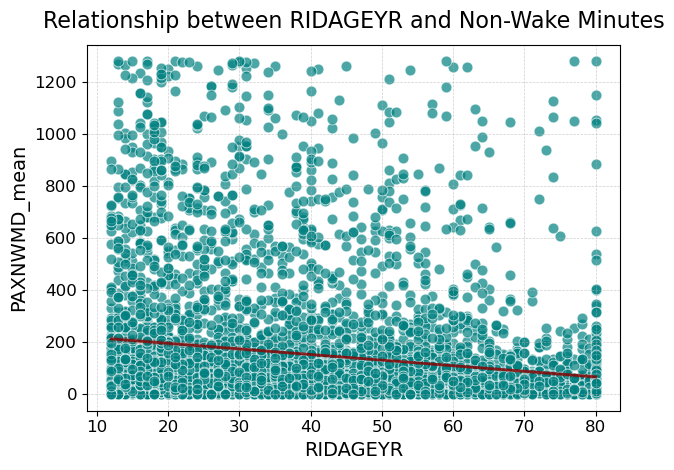

In [48]:
sns.scatterplot(
    data=merged_data,
    x='RIDAGEYR',                # e.g. 'Age'
    y='PAXNWMD_mean',                # e.g. 'PA_mean'
    color='teal',             # single color; seaborn palettes also available :contentReference[oaicite:1]{index=1}
    s=60,                     # point size
    alpha=0.7,                # transparency
    edgecolor='w',            # white border around points for clarity
)

# 4. Add a light regression line (optional)
sns.regplot(
    data=merged_data,
    x='RIDAGEYR',
    y='PAXNWMD_mean',
    scatter=False,
    color='darkred',
    line_kws={'linewidth': 2, 'alpha': 0.8},
)

# 5. Customize axes and title
plt.title('Relationship between RIDAGEYR and Non-Wake Minutes', fontsize=16, pad=12)
plt.xlabel('RIDAGEYR', fontsize=14)
plt.ylabel('PAXNWMD_mean', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 6. Fine‑tune grid and layout
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()

# 7. Show the plot
plt.show()

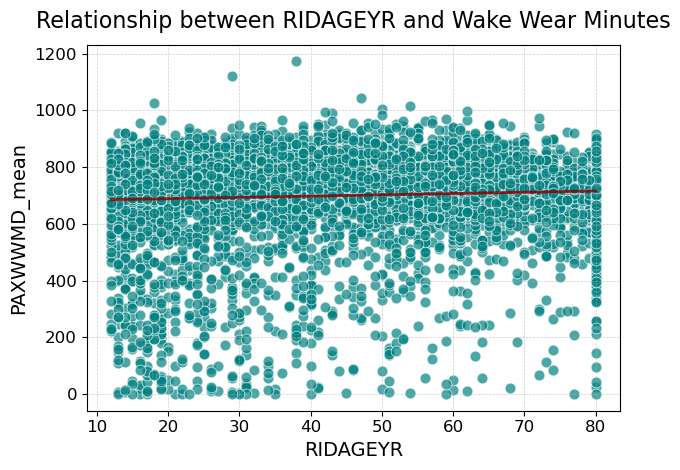

In [49]:
sns.scatterplot(
    data=merged_data,
    x='RIDAGEYR',                # e.g. 'Age'
    y='PAXWWMD_mean',                # e.g. 'PA_mean'
    color='teal',             # single color; seaborn palettes also available :contentReference[oaicite:1]{index=1}
    s=60,                     # point size
    alpha=0.7,                # transparency
    edgecolor='w',            # white border around points for clarity
)

# 4. Add a light regression line (optional)
sns.regplot(
    data=merged_data,
    x='RIDAGEYR',
    y='PAXWWMD_mean',
    scatter=False,
    color='darkred',
    line_kws={'linewidth': 2, 'alpha': 0.8},
)

# 5. Customize axes and title
plt.title('Relationship between RIDAGEYR and Wake Wear Minutes', fontsize=16, pad=12)
plt.xlabel('RIDAGEYR', fontsize=14)
plt.ylabel('PAXWWMD_mean', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 6. Fine‑tune grid and layout
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()

# 7. Show the plot
plt.show()

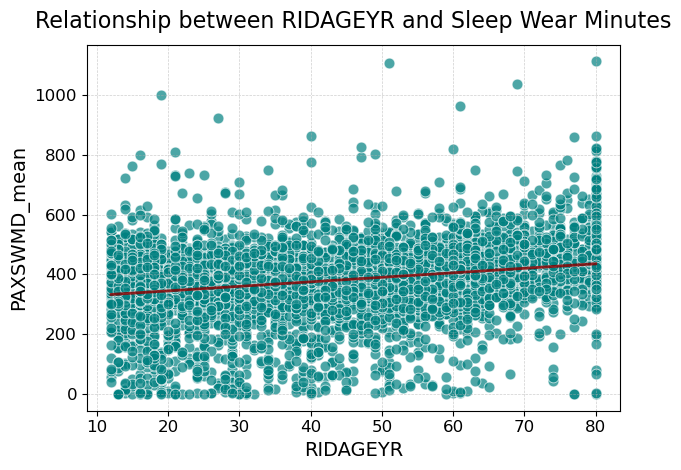

In [50]:
sns.scatterplot(
    data=merged_data,
    x='RIDAGEYR',                # e.g. 'Age'
    y='PAXSWMD_mean',                # e.g. 'PA_mean'
    color='teal',             # single color; seaborn palettes also available :contentReference[oaicite:1]{index=1}
    s=60,                     # point size
    alpha=0.7,                # transparency
    edgecolor='w',            # white border around points for clarity
)

# 4. Add a light regression line (optional)
sns.regplot(
    data=merged_data,
    x='RIDAGEYR',
    y='PAXSWMD_mean',
    scatter=False,
    color='darkred',
    line_kws={'linewidth': 2, 'alpha': 0.8},
)

# 5. Customize axes and title
plt.title('Relationship between RIDAGEYR and Sleep Wear Minutes', fontsize=16, pad=12)
plt.xlabel('RIDAGEYR', fontsize=14)
plt.ylabel('PAXSWMD_mean', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 6. Fine‑tune grid and layout
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()

# 7. Show the plot
plt.show()

In [51]:
merged_data.isnull().sum()

SEQN            0
PAXMTSD_mean    0
PAXMTSD_std     0
PAXWWMD_mean    0
PAXWWMD_std     0
PAXSWMD_mean    0
PAXSWMD_std     0
PAXNWMD_mean    0
PAXNWMD_std     0
PAQ605          0
PAQ620          0
PAQ635          0
PAQ650          0
PAQ665          0
RIAGENDR        0
RIDAGEYR        0
DMDBORN4        0
INDHHIN2        0
DMDHHSIZ        0
DMDHREDU        0
dtype: int64

In [52]:
merged_data.head()

,SEQN,PAXMTSD_mean,PAXMTSD_std,PAXWWMD_mean,PAXWWMD_std,PAXSWMD_mean,PAXSWMD_std,PAXNWMD_mean,PAXNWMD_std,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665,RIAGENDR,RIDAGEYR,DMDBORN4,INDHHIN2,DMDHHSIZ,DMDHREDU
0,62161.0,10702.718222,5558.563548,733.888889,308.413863,388.888889,205.754371,102.111111,252.250096,2.0,2.0,2.0,2.0,2.0,1.0,22.0,1.0,14.0,5.0,5.0
1,62163.0,13116.369667,7252.090094,805.111111,334.380937,375.888889,181.596699,53.888889,161.666667,2.0,2.0,1.0,2.0,2.0,1.0,14.0,1.0,15.0,5.0,5.0
2,62164.0,11624.051000,4182.303206,818.777778,282.408736,373.111111,164.884387,22.555556,67.666667,1.0,2.0,2.0,1.0,1.0,2.0,44.0,1.0,8.0,5.0,4.0
3,62165.0,18516.184778,6788.305624,840.888889,226.521767,379.000000,199.953745,25.111111,75.333333,2.0,2.0,1.0,1.0,1.0,2.0,14.0,1.0,4.0,5.0,2.0
4,62169.0,8893.430667,3980.224218,817.333333,279.022849,383.777778,158.229088,7.888889,23.666667,2.0,2.0,2.0,2.0,2.0,1.0,21.0,1.0,2.0,5.0,1.0


In [53]:
health_status = pd.read_csv('HSQ.csv')

In [54]:
health_status.drop( columns=['HSQ480', 'HSQ490', 'HSQ493', 'HSQ496', 'HSQ500', 'HSQ510',
       'HSQ520', 'HSQ571', 'HSQ580', 'HSQ590','HSAQUEX'] , inplace = True )

In [55]:
health_status.shape

(8956, 3)

In [56]:
total_data = pd.merge(merged_data, health_status, on = 'SEQN', how='inner')

In [57]:
total_data.shape

(5741, 22)

In [58]:
total_data.isnull().sum()

SEQN              0
PAXMTSD_mean      0
PAXMTSD_std       0
PAXWWMD_mean      0
PAXWWMD_std       0
PAXSWMD_mean      0
PAXSWMD_std       0
PAXNWMD_mean      0
PAXNWMD_std       0
PAQ605            0
PAQ620            0
PAQ635            0
PAQ650            0
PAQ665            0
RIAGENDR          0
RIDAGEYR          0
DMDBORN4          0
INDHHIN2          0
DMDHHSIZ          0
DMDHREDU          0
HSD010          410
HSQ470          410
dtype: int64

In [59]:
total_data.dropna(inplace = True)

In [60]:
total_data.shape

(5331, 22)

In [61]:
total_data.isnull().sum()

SEQN            0
PAXMTSD_mean    0
PAXMTSD_std     0
PAXWWMD_mean    0
PAXWWMD_std     0
PAXSWMD_mean    0
PAXSWMD_std     0
PAXNWMD_mean    0
PAXNWMD_std     0
PAQ605          0
PAQ620          0
PAQ635          0
PAQ650          0
PAQ665          0
RIAGENDR        0
RIDAGEYR        0
DMDBORN4        0
INDHHIN2        0
DMDHHSIZ        0
DMDHREDU        0
HSD010          0
HSQ470          0
dtype: int64

In [62]:
med_dis_data = pd.read_csv('med_dis_data.csv')

In [63]:
med_dis_data.drop(columns= ['MCQ010', 'MCQ025', 'MCQ035', 'MCQ040', 'MCQ050', 'MCQ051',
       'MCQ053', 'MCQ070', 'MCQ075', 'MCQ080', 'MCQ082', 'MCQ084', 'MCQ086',
       'MCQ092', 'MCD093', 'MCQ140', 'MCQ149', 'MCQ180A', 'MCQ195',
       'MCQ160N', 'MCQ180N', 'MCQ160B', 'MCQ180B', 'MCQ160C', 'MCQ180C',
       'MCQ160D', 'MCQ180D', 'MCQ160E', 'MCQ180E', 'MCQ160F', 'MCQ180F',
       'MCQ160G', 'MCQ180G', 'MCQ160M', 'MCQ170M', 'MCQ180M', 'MCQ160K',
       'MCQ170K', 'MCQ180K', 'MCQ160L', 'MCQ170L', 'MCQ180L', 'MCQ220',
       'MCQ230A', 'MCQ230B', 'MCQ230C', 'MCQ230D', 'MCQ240A', 'MCQ240AA',
       'MCQ240B', 'MCQ240BB', 'MCQ240C', 'MCQ240CC', 'MCQ240D', 'MCQ240DD',
       'MCQ240DK', 'MCQ240E', 'MCQ240F', 'MCQ240G', 'MCQ240H', 'MCQ240I',
       'MCQ240J', 'MCQ240K', 'MCQ240L', 'MCQ240M', 'MCQ240N', 'MCQ240O',
       'MCQ240P', 'MCQ240Q', 'MCQ240R', 'MCQ240S', 'MCQ240T', 'MCQ240U',
       'MCQ240V', 'MCQ240W', 'MCQ240X', 'MCQ240Y', 'MCQ240Z', 'MCQ300A',
       'MCQ300B', 'MCQ300C', 'MCQ365C', 'MCQ365D',
       'MCQ370C', 'MCQ370D', 'MCQ380'], inplace= True)

In [64]:
med_dis_data.head()

,SEQN,MCQ160A,MCQ365A,MCQ365B,MCQ370A,MCQ370B
0,62161.0,2.0,1.0,2.0,1.0,1.0
1,62162.0,NaN,NaN,NaN,NaN,NaN
2,62163.0,NaN,NaN,NaN,NaN,NaN
3,62164.0,2.0,2.0,2.0,1.0,1.0
4,62165.0,NaN,NaN,NaN,NaN,NaN


In [65]:
total_data = total_data.merge(med_dis_data, on = 'SEQN', how = 'inner')

In [66]:
total_data.shape

(5331, 27)

In [67]:
total_data.isnull().sum()

SEQN               0
PAXMTSD_mean       0
PAXMTSD_std        0
PAXWWMD_mean       0
PAXWWMD_std        0
PAXSWMD_mean       0
PAXSWMD_std        0
PAXNWMD_mean       0
PAXNWMD_std        0
PAQ605             0
PAQ620             0
PAQ635             0
PAQ650             0
PAQ665             0
RIAGENDR           0
RIDAGEYR           0
DMDBORN4           0
INDHHIN2           0
DMDHHSIZ           0
DMDHREDU           0
HSD010             0
HSQ470             0
MCQ160A         1077
MCQ365A          550
MCQ365B          550
MCQ370A          550
MCQ370B          550
dtype: int64

In [68]:
total_data.dropna(inplace = True)

In [69]:
total_data.shape

(4254, 27)

In [70]:
total_data.isnull().sum()

SEQN            0
PAXMTSD_mean    0
PAXMTSD_std     0
PAXWWMD_mean    0
PAXWWMD_std     0
PAXSWMD_mean    0
PAXSWMD_std     0
PAXNWMD_mean    0
PAXNWMD_std     0
PAQ605          0
PAQ620          0
PAQ635          0
PAQ650          0
PAQ665          0
RIAGENDR        0
RIDAGEYR        0
DMDBORN4        0
INDHHIN2        0
DMDHHSIZ        0
DMDHREDU        0
HSD010          0
HSQ470          0
MCQ160A         0
MCQ365A         0
MCQ365B         0
MCQ370A         0
MCQ370B         0
dtype: int64

In [71]:
total_data.head(20)

,SEQN,PAXMTSD_mean,PAXMTSD_std,PAXWWMD_mean,PAXWWMD_std,PAXSWMD_mean,PAXSWMD_std,PAXNWMD_mean,PAXNWMD_std,PAQ605,...,INDHHIN2,DMDHHSIZ,DMDHREDU,HSD010,HSQ470,MCQ160A,MCQ365A,MCQ365B,MCQ370A,MCQ370B
0,62161.0,10702.718222,5558.563548,733.888889,308.413863,388.888889,205.754371,102.111111,252.250096,2.0,...,14.0,5.0,5.0,3.0,5.397605e-79,2.0,1.0,2.0,1.0,1.0
3,62169.0,8893.430667,3980.224218,817.333333,279.022849,383.777778,158.229088,7.888889,23.666667,2.0,...,2.0,5.0,1.0,3.0,1.000000e+01,2.0,2.0,2.0,2.0,2.0
6,62172.0,2552.998000,3791.624514,136.111111,207.170488,105.555556,170.955485,1025.444444,534.966847,2.0,...,5.0,1.0,3.0,3.0,2.000000e+00,2.0,2.0,2.0,1.0,1.0
7,62174.0,7157.632778,3737.068057,713.444444,332.195391,380.444444,199.968817,126.444444,350.682945,2.0,...,10.0,2.0,4.0,4.0,3.000000e+01,1.0,1.0,1.0,1.0,1.0
8,62178.0,6551.497556,2129.729791,632.777778,213.616934,551.222222,167.822658,26.222222,78.666667,2.0,...,1.0,1.0,3.0,4.0,2.000000e+00,1.0,2.0,2.0,2.0,1.0
9,62179.0,5681.822500,1765.332384,428.000000,239.002092,235.500000,164.755880,0.000000,0.000000,2.0,...,15.0,4.0,5.0,2.0,5.397605e-79,2.0,2.0,1.0,1.0,2.0
10,62180.0,11616.198444,5399.015617,772.777778,348.542959,403.222222,142.729445,58.666667,176.000000,2.0,...,5.0,4.0,5.0,3.0,5.397605e-79,2.0,2.0,2.0,1.0,2.0
11,62184.0,12185.490333,3796.955736,838.000000,228.058107,394.888889,156.896817,1.222222,3.666667,1.0,...,15.0,7.0,4.0,3.0,5.397605e-79,2.0,2.0,2.0,2.0,1.0
13,62189.0,15282.661444,5932.221775,855.444444,310.951809,297.444444,144.245547,99.222222,183.663944,2.0,...,10.0,4.0,4.0,2.0,5.397605e-79,2.0,2.0,2.0,1.0,2.0
15,62191.0,6287.154111,2520.143523,643.888889,244.478754,558.444444,172.361619,18.555556,55.666667,2.0,...,14.0,2.0,6.0,3.0,5.397605e-79,2.0,2.0,2.0,1.0,2.0


In [72]:
total_data['PAQ605'] = total_data['PAQ605'].replace({2:1,1:0})
total_data['PAQ620'] = total_data['PAQ620'].replace({2:1,1:0})
total_data['PAQ635'] = total_data['PAQ635'].replace({2:1,1:0})
total_data['PAQ650'] = total_data['PAQ650'].replace({2:1,1:0})
total_data['PAQ665'] = total_data['PAQ665'].replace({2:1,1:0})
total_data['MCQ160A'] = total_data['MCQ160A'].replace({2:0,1:1})
total_data['MCQ365A'] = total_data['MCQ365A'].replace({2:0,1:1})
total_data['MCQ365B'] = total_data['MCQ365B'].replace({2:0,1:1})
total_data['MCQ370A'] = total_data['MCQ370A'].replace({2:0,1:1})
total_data['MCQ370B'] = total_data['MCQ370B'].replace({2:0,1:1})
total_data['RIAGENDR'] = total_data['RIAGENDR'].replace({2:1,1:0})
total_data['DMDBORN4'] = total_data['DMDBORN4'].replace({2:1,1:0})
total_data['HSD010'] = total_data['HSD010'].replace([1, 2, 3], 0).replace([4, 5], 1)
total_data['INDHHIN2'] = total_data['INDHHIN2'].replace([1,2,3,4,13],1).replace([5,6,7],2).replace([8,9,10],3).replace([14,15],4).replace([12],5)
total_data['DMDHHSIZ'] = total_data['DMDHHSIZ'].replace([2,3,4],2).replace([5,6,7],3)

In [73]:
pd.set_option('display.max_columns', None)

In [74]:
total_data.head(20)

,SEQN,PAXMTSD_mean,PAXMTSD_std,PAXWWMD_mean,PAXWWMD_std,PAXSWMD_mean,PAXSWMD_std,PAXNWMD_mean,PAXNWMD_std,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665,RIAGENDR,RIDAGEYR,DMDBORN4,INDHHIN2,DMDHHSIZ,DMDHREDU,HSD010,HSQ470,MCQ160A,MCQ365A,MCQ365B,MCQ370A,MCQ370B
0,62161.0,10702.718222,5558.563548,733.888889,308.413863,388.888889,205.754371,102.111111,252.250096,1.0,1.0,1.0,1.0,1.0,0.0,22.0,0.0,4.0,3.0,5.0,0.0,5.397605e-79,0.0,1.0,0.0,1.0,1.0
3,62169.0,8893.430667,3980.224218,817.333333,279.022849,383.777778,158.229088,7.888889,23.666667,1.0,1.0,1.0,1.0,1.0,0.0,21.0,0.0,1.0,3.0,1.0,0.0,1.000000e+01,0.0,0.0,0.0,0.0,0.0
6,62172.0,2552.998000,3791.624514,136.111111,207.170488,105.555556,170.955485,1025.444444,534.966847,1.0,1.0,1.0,1.0,1.0,1.0,43.0,0.0,2.0,1.0,3.0,0.0,2.000000e+00,0.0,0.0,0.0,1.0,1.0
7,62174.0,7157.632778,3737.068057,713.444444,332.195391,380.444444,199.968817,126.444444,350.682945,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,3.0,2.0,4.0,1.0,3.000000e+01,1.0,1.0,1.0,1.0,1.0
8,62178.0,6551.497556,2129.729791,632.777778,213.616934,551.222222,167.822658,26.222222,78.666667,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,3.0,1.0,2.000000e+00,1.0,0.0,0.0,0.0,1.0
9,62179.0,5681.822500,1765.332384,428.000000,239.002092,235.500000,164.755880,0.000000,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,55.0,0.0,4.0,2.0,5.0,0.0,5.397605e-79,0.0,0.0,1.0,1.0,0.0
10,62180.0,11616.198444,5399.015617,772.777778,348.542959,403.222222,142.729445,58.666667,176.000000,1.0,1.0,1.0,1.0,1.0,0.0,35.0,0.0,2.0,2.0,5.0,0.0,5.397605e-79,0.0,0.0,0.0,1.0,0.0
11,62184.0,12185.490333,3796.955736,838.000000,228.058107,394.888889,156.896817,1.222222,3.666667,0.0,1.0,1.0,0.0,1.0,0.0,26.0,0.0,4.0,3.0,4.0,0.0,5.397605e-79,0.0,0.0,0.0,0.0,1.0
13,62189.0,15282.661444,5932.221775,855.444444,310.951809,297.444444,144.245547,99.222222,183.663944,1.0,0.0,1.0,1.0,1.0,1.0,30.0,0.0,3.0,2.0,4.0,0.0,5.397605e-79,0.0,0.0,0.0,1.0,0.0
15,62191.0,6287.154111,2520.143523,643.888889,244.478754,558.444444,172.361619,18.555556,55.666667,1.0,1.0,1.0,1.0,0.0,0.0,70.0,0.0,4.0,2.0,6.0,0.0,5.397605e-79,0.0,0.0,0.0,1.0,0.0


In [75]:
total_data.drop( columns = ['HSQ470'], inplace = True )

In [76]:
total_data.shape

(4254, 26)

In [77]:
cols_to_standardize = ['PAXMTSD_mean', 'PAXMTSD_std', 'PAXSWMD_mean', 'PAXSWMD_std','PAXNWMD_mean','PAXNWMD_std','PAXWWMD_mean','PAXWWMD_std']


In [78]:
print(total_data[cols_to_standardize].describe())


       PAXMTSD_mean   PAXMTSD_std  PAXSWMD_mean  PAXSWMD_std  PAXNWMD_mean  \
count   4254.000000   4254.000000   4254.000000  4254.000000   4254.000000   
mean   10354.676329   4860.991037    386.886005   176.321046    130.174132   
std     3540.652588   1834.522056    120.602974    67.272797    213.793082   
min        2.722444      3.624971      0.000000     0.000000      0.000000   
25%     8124.874611   3654.031736    333.111111   137.234672     21.361111   
50%    10411.612667   4731.365081    391.555556   165.345009     53.555556   
75%    12649.835528   5930.030579    452.000000   202.158291    132.222222   
max    29613.147667  20384.885295   1111.888889   677.791450   1281.111111   

       PAXNWMD_std  PAXWWMD_mean  PAXWWMD_std  
count  4254.000000   4254.000000  4254.000000  
mean    178.196097    706.898917   306.535132  
std     150.654836    159.693492    68.607072  
min       0.000000      0.000000     0.000000  
25%      61.666667    657.722222   267.236591  
50%     1

In [79]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the specified columns
# This updates the columns in-place
total_data[cols_to_standardize] = scaler.fit_transform(total_data[cols_to_standardize])

# Check the standardized values
print(total_data[cols_to_standardize].describe())


       PAXMTSD_mean   PAXMTSD_std  PAXSWMD_mean   PAXSWMD_std  PAXNWMD_mean  \
count  4.254000e+03  4.254000e+03  4.254000e+03  4.254000e+03  4.254000e+03   
mean  -6.221842e-17 -2.037758e-16 -4.008704e-17  2.125448e-16  1.023055e-16   
std    1.000118e+00  1.000118e+00  1.000118e+00  1.000118e+00  1.000118e+00   
min   -2.924085e+00 -2.648067e+00 -3.208308e+00 -2.621294e+00 -6.089506e-01   
25%   -6.298454e-01 -6.579922e-01 -4.459361e-01 -5.810814e-01 -5.090240e-01   
50%    1.608264e-02 -7.066756e-02  3.872292e-02 -1.631763e-01 -3.584194e-01   
75%    6.483068e-01  5.828031e-01  5.399672e-01  3.841119e-01  9.580904e-03   
max    5.439883e+00  8.463087e+00  6.012191e+00  7.455158e+00  5.384048e+00   

        PAXNWMD_std  PAXWWMD_mean   PAXWWMD_std  
count  4.254000e+03  4.254000e+03  4.254000e+03  
mean  -2.330059e-16 -3.566076e-16 -2.831147e-16  
std    1.000118e+00  1.000118e+00  1.000118e+00  
min   -1.182949e+00 -4.427119e+00 -4.468507e+00  
25%   -7.735771e-01 -3.079805e-01 -5.7

In [80]:
total_data[cols_to_standardize] = total_data[cols_to_standardize].round(3)

In [81]:
total_data.head()

,SEQN,PAXMTSD_mean,PAXMTSD_std,PAXWWMD_mean,PAXWWMD_std,PAXSWMD_mean,PAXSWMD_std,PAXNWMD_mean,PAXNWMD_std,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665,RIAGENDR,RIDAGEYR,DMDBORN4,INDHHIN2,DMDHHSIZ,DMDHREDU,HSD010,MCQ160A,MCQ365A,MCQ365B,MCQ370A,MCQ370B
0,62161.0,0.098,0.380,0.169,0.027,0.017,0.438,-0.131,0.492,1.0,1.0,1.0,1.0,1.0,0.0,22.0,0.0,4.0,3.0,5.0,0.0,0.0,1.0,0.0,1.0,1.0
3,62169.0,-0.413,-0.480,0.692,-0.401,-0.026,-0.269,-0.572,-1.026,1.0,1.0,1.0,1.0,1.0,0.0,21.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,62172.0,-2.204,-0.583,-3.575,-1.448,-2.333,-0.080,4.188,2.368,1.0,1.0,1.0,1.0,1.0,1.0,43.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0
7,62174.0,-0.903,-0.613,0.041,0.374,-0.053,0.352,-0.017,1.145,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,3.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
8,62178.0,-1.074,-1.489,-0.464,-1.355,1.363,-0.126,-0.486,-0.661,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0


In [82]:
new_column_names = ['SEQN','PA_mean','PA_std','WW_mean','WW_std','SW_mean','SW_std','NW_mean','NW_std','VWA','MWA','W/B','VRC','MRC','Gender','Age','US_born','HH_Income','HH_size','Edu_level','Health_status','Arthritis','Lose_weight','Excercise','Con_lost_weight','increase_exercise']

In [83]:
total_data.columns = new_column_names

In [84]:
total_data.dtypes

SEQN                 float64
PA_mean              float64
PA_std               float64
WW_mean              float64
WW_std               float64
SW_mean              float64
SW_std               float64
NW_mean              float64
NW_std               float64
VWA                  float64
MWA                  float64
W/B                  float64
VRC                  float64
MRC                  float64
Gender               float64
Age                  float64
US_born              float64
HH_Income            float64
HH_size              float64
Edu_level            float64
Health_status        float64
Arthritis            float64
Lose_weight          float64
Excercise            float64
Con_lost_weight      float64
increase_exercise    float64
dtype: object

In [85]:
total_data.shape


(4254, 26)

In [86]:
total_data.isnull().sum()

SEQN                 0
PA_mean              0
PA_std               0
WW_mean              0
WW_std               0
SW_mean              0
SW_std               0
NW_mean              0
NW_std               0
VWA                  0
MWA                  0
W/B                  0
VRC                  0
MRC                  0
Gender               0
Age                  0
US_born              0
HH_Income            0
HH_size              0
Edu_level            0
Health_status        0
Arthritis            0
Lose_weight          0
Excercise            0
Con_lost_weight      0
increase_exercise    0
dtype: int64

In [87]:
graph_data = total_data.copy()

/var/folders/y4/n3fdqm1146z433bf3l7m6hx80000gn/T/ipykernel_7947/2790198163.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = graph_data.groupby('Age_bin')[binary_cols].mean().reset_index()


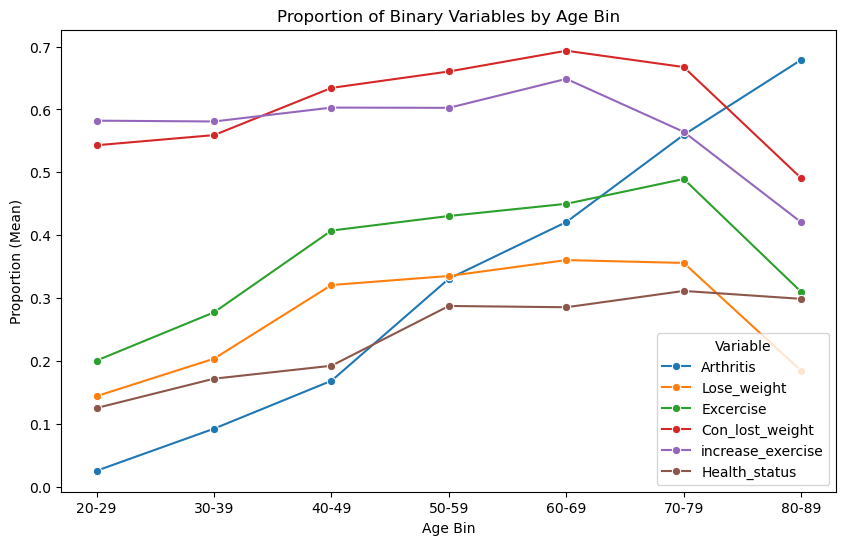

In [88]:
# Define age bins and labels (adjust bins as needed based on your data's age range)
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89']
graph_data['Age_bin'] = pd.cut(graph_data['Age'], bins=bins, labels=labels, right=False)

# List of binary columns to analyze
binary_cols = ['Arthritis', 'Lose_weight', 'Excercise', 'Con_lost_weight', 'increase_exercise', 'Health_status']

# Group the data by Age_bin and calculate the mean for binary columns (proportion of 1's)
grouped = graph_data.groupby('Age_bin')[binary_cols].mean().reset_index()

# Plot using a line plot
plt.figure(figsize=(10, 6))
for col in binary_cols:
    sns.lineplot(x='Age_bin', y=col, data=grouped, marker='o', label=col)

plt.title('Proportion of Binary Variables by Age Bin')
plt.xlabel('Age Bin')
plt.ylabel('Proportion (Mean)')
plt.legend(title='Variable')
plt.show()



MCQ160a - Doctor ever said you had arthritis

MCQ365a - Doctor told you to lose weight

MCQ365b - Doctor told you to exercise

MCQ370a - Are you now controlling or losing weight

MCQ370b - Are you now increasing exercise

/var/folders/y4/n3fdqm1146z433bf3l7m6hx80000gn/T/ipykernel_7947/3651070951.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = graph_data.groupby('Age_bin')['Arthritis'].mean().reset_index()


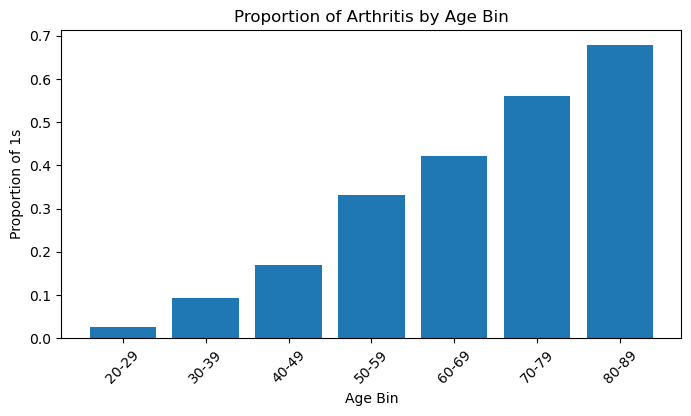

In [90]:

# Group the data by age_bin and calculate the mean of arthritis column.
# (Assuming arthritis is binary: 1 for having arthritis and 0 for not.)
grouped = graph_data.groupby('Age_bin')['Arthritis'].mean().reset_index()

plt.figure(figsize=(8, 4))
plt.bar(grouped['Age_bin'], grouped['Arthritis'])
plt.title('Proportion of Arthritis by Age Bin')
plt.xlabel('Age Bin')
plt.ylabel('Proportion of 1s')
plt.xticks(rotation=45)  # Rotate the labels if they are overlapping
plt.show()


In [91]:
graph_data.columns


Index(['SEQN', 'PA_mean', 'PA_std', 'WW_mean', 'WW_std', 'SW_mean', 'SW_std',
       'NW_mean', 'NW_std', 'VWA', 'MWA', 'W/B', 'VRC', 'MRC', 'Gender', 'Age',
       'US_born', 'HH_Income', 'HH_size', 'Edu_level', 'Health_status',
       'Arthritis', 'Lose_weight', 'Excercise', 'Con_lost_weight',
       'increase_exercise', 'Age_bin'],
      dtype='object')

In [92]:
graph_data.head()

,SEQN,PA_mean,PA_std,WW_mean,WW_std,SW_mean,SW_std,NW_mean,NW_std,VWA,MWA,W/B,VRC,MRC,Gender,Age,US_born,HH_Income,HH_size,Edu_level,Health_status,Arthritis,Lose_weight,Excercise,Con_lost_weight,increase_exercise,Age_bin
0,62161.0,0.098,0.380,0.169,0.027,0.017,0.438,-0.131,0.492,1.0,1.0,1.0,1.0,1.0,0.0,22.0,0.0,4.0,3.0,5.0,0.0,0.0,1.0,0.0,1.0,1.0,20-29
3,62169.0,-0.413,-0.480,0.692,-0.401,-0.026,-0.269,-0.572,-1.026,1.0,1.0,1.0,1.0,1.0,0.0,21.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20-29
6,62172.0,-2.204,-0.583,-3.575,-1.448,-2.333,-0.080,4.188,2.368,1.0,1.0,1.0,1.0,1.0,1.0,43.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,40-49
7,62174.0,-0.903,-0.613,0.041,0.374,-0.053,0.352,-0.017,1.145,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,3.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,80-89
8,62178.0,-1.074,-1.489,-0.464,-1.355,1.363,-0.126,-0.486,-0.661,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,80-89


In [93]:
import pandas as pd
from scipy import stats

# Assuming your data is loaded in a DataFrame named graph_data
# Define the list of binary columns
binary_cols = ['Arthritis', 'Lose_weight', 'Excercise', 'Con_lost_weight', 'increase_exercise']

# Loop over each binary column and perform the t-test on PA_mean
for col in binary_cols:
    # Split PA_mean values based on the binary column
    group0 = graph_data.loc[graph_data[col] == 0, 'PA_mean']
    group1 = graph_data.loc[graph_data[col] == 1, 'PA_mean']
    
    # Perform an independent samples t-test with handling of NaN values
    t_stat, p_value = stats.ttest_ind(group0, group1, nan_policy='omit')
    
    # Print the results in a formatted string
    print(f"T-test for PA_mean by {col}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")


T-test for PA_mean by Arthritis: t-statistic = 9.5609, p-value = 0.0000
T-test for PA_mean by Lose_weight: t-statistic = 4.4075, p-value = 0.0000
T-test for PA_mean by Excercise: t-statistic = 6.0306, p-value = 0.0000
T-test for PA_mean by Con_lost_weight: t-statistic = -0.7429, p-value = 0.4576
T-test for PA_mean by increase_exercise: t-statistic = -1.7911, p-value = 0.0733


In [94]:
for col in binary_cols:
    # Split PA_mean values based on the binary column
    group0 = graph_data.loc[graph_data[col] == 0, 'WW_mean']
    group1 = graph_data.loc[graph_data[col] == 1, 'WW_mean']
    
    # Perform an independent samples t-test with handling of NaN values
    t_stat, p_value = stats.ttest_ind(group0, group1, nan_policy='omit')
    
    # Print the results in a formatted string
    print(f"T-test for Wake_Wear_mean by {col}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

T-test for Wake_Wear_mean by Arthritis: t-statistic = 2.0656, p-value = 0.0389
T-test for Wake_Wear_mean by Lose_weight: t-statistic = -1.1955, p-value = 0.2320
T-test for Wake_Wear_mean by Excercise: t-statistic = 0.4473, p-value = 0.6547
T-test for Wake_Wear_mean by Con_lost_weight: t-statistic = -3.2517, p-value = 0.0012
T-test for Wake_Wear_mean by increase_exercise: t-statistic = -2.6801, p-value = 0.0074


In [95]:
for col in binary_cols:
    # Split Sleep_Wear_mean values based on the binary column
    group0 = graph_data.loc[graph_data[col] == 0, 'SW_mean']
    group1 = graph_data.loc[graph_data[col] == 1, 'SW_mean']
    
    # Perform an independent samples t-test with handling of NaN values
    t_stat, p_value = stats.ttest_ind(group0, group1, nan_policy='omit')
    
    # Print the results in a formatted string
    print(f"T-test for Sleep_Wear_mean by {col}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

T-test for Sleep_Wear_mean by Arthritis: t-statistic = -10.0044, p-value = 0.0000
T-test for Sleep_Wear_mean by Lose_weight: t-statistic = -2.2252, p-value = 0.0261
T-test for Sleep_Wear_mean by Excercise: t-statistic = -3.7221, p-value = 0.0002
T-test for Sleep_Wear_mean by Con_lost_weight: t-statistic = 0.9132, p-value = 0.3612
T-test for Sleep_Wear_mean by increase_exercise: t-statistic = 2.2781, p-value = 0.0228


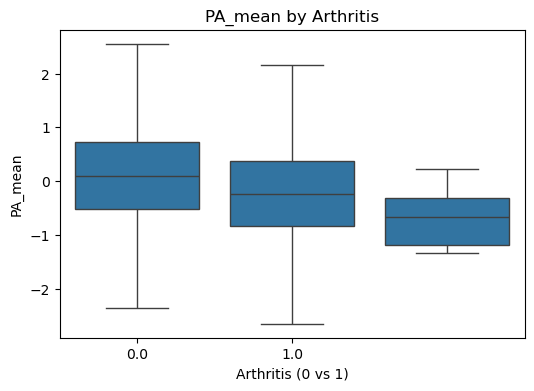

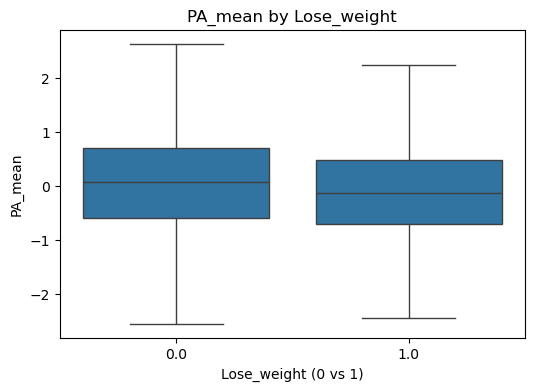

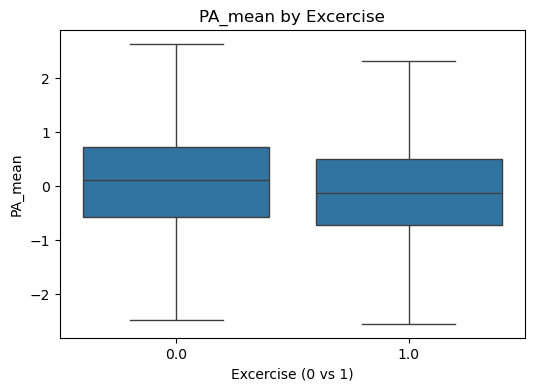

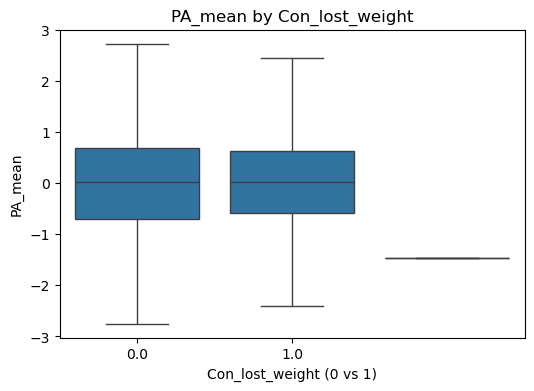

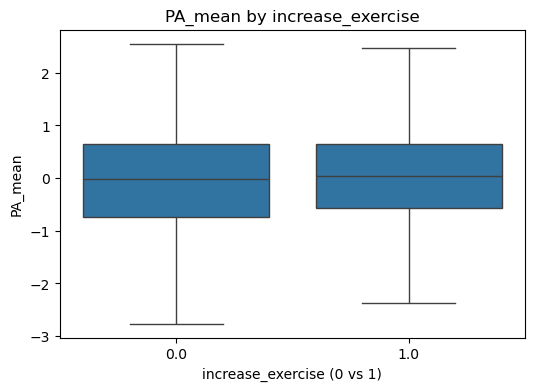

In [96]:
# List your binary columns
binary_cols = ['Arthritis', 'Lose_weight', 'Excercise', 
               'Con_lost_weight', 'increase_exercise']

for col in binary_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=graph_data[col], y=graph_data['PA_mean'], showfliers=False)
    plt.title(f'PA_mean by {col}')
    plt.xlabel(col + ' (0 vs 1)')
    plt.ylabel('PA_mean')
    plt.xticks([0, 1])           # ensure ticks show both categories
    plt.show()


In [97]:
graph_data['Con_lost_weight'].value_counts()


Con_lost_weight
1.0    2608
0.0    1645
9.0       1
Name: count, dtype: int64

In [98]:
graph_data['Arthritis'].value_counts()


Arthritis
0.0    3134
1.0    1114
9.0       6
Name: count, dtype: int64

In [99]:
graph_data['Lose_weight'].value_counts()


Lose_weight
0.0    3083
1.0    1171
Name: count, dtype: int64

In [100]:
graph_data['Excercise'].value_counts()


Excercise
0.0    2707
1.0    1547
Name: count, dtype: int64

In [101]:
graph_data['increase_exercise'].value_counts()

increase_exercise
1.0    2503
0.0    1751
Name: count, dtype: int64

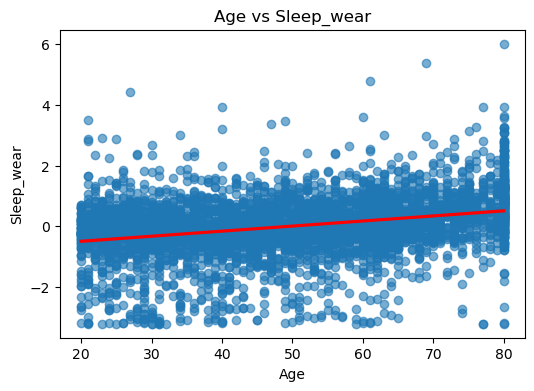

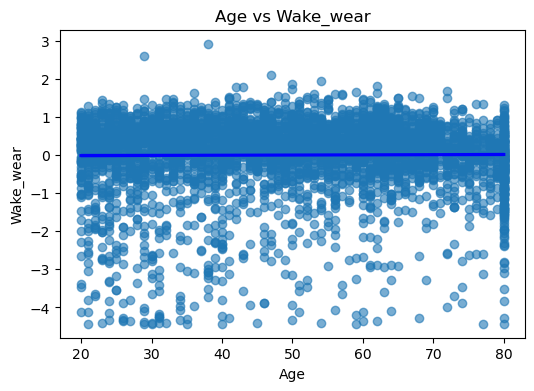

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot: Age vs Sleep_wear with regression line
plt.figure(figsize=(6, 4))
sns.regplot(
    data=graph_data,
    x='Age',
    y='SW_mean',
    scatter_kws={'alpha': 0.6},   # semi‑transparent points
    line_kws={'color': 'red'}     # regression line in red
)
plt.title('Age vs Sleep_wear')
plt.xlabel('Age')
plt.ylabel('Sleep_wear')
plt.show()

# Plot: Age vs Non‑sleep_wear with regression line
plt.figure(figsize=(6, 4))
sns.regplot(
    data=graph_data,
    x='Age',
    y='WW_mean',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'blue'}
)
plt.title('Age vs Wake_wear')
plt.xlabel('Age')
plt.ylabel('Wake_wear')
plt.show()


# Dividing the Dataset into poeple more than 68 years old and below 68 year old. 

In [104]:
# Participants aged 68 and above
df_68 = total_data[total_data['Age'] >= 68].copy()

# Participants below age 68
df_below_68 = total_data[total_data['Age'] < 68].copy()

# (Optional) Reset the indices if you like
df_68.reset_index(drop=True, inplace=True)
df_below_68.reset_index(drop=True, inplace=True)

# Quick sanity check
print(f"68+ count: {len(df_68)}")
print(f"<68 count: {len(df_below_68)}")


68+ count: 815
<68 count: 3439


# Building the Machine Learning Models without the divided data based on age.

In [106]:
machine_data = total_data.copy()

In [107]:
machine_data.shape

(4254, 26)

In [108]:
machine_data.isnull().sum()

SEQN                 0
PA_mean              0
PA_std               0
WW_mean              0
WW_std               0
SW_mean              0
SW_std               0
NW_mean              0
NW_std               0
VWA                  0
MWA                  0
W/B                  0
VRC                  0
MRC                  0
Gender               0
Age                  0
US_born              0
HH_Income            0
HH_size              0
Edu_level            0
Health_status        0
Arthritis            0
Lose_weight          0
Excercise            0
Con_lost_weight      0
increase_exercise    0
dtype: int64

In [109]:
machine_data['HH_Income'].value_counts()

HH_Income
2.0     1187
4.0     1052
1.0     1012
3.0      662
16.0     174
5.0      167
Name: count, dtype: int64

In [110]:
machine_data['HH_size'].value_counts()


HH_size
2.0    2809
3.0     811
1.0     634
Name: count, dtype: int64

In [111]:
machine_data['Edu_level'].value_counts()


Edu_level
4.0    1213
5.0    1075
3.0     864
2.0     576
1.0     367
6.0     159
Name: count, dtype: int64

In [112]:

# List the columns you want to create dummy variables for
dummy_cols = ['HH_Income', 'HH_size', 'Edu_level']

# Convert these columns to string so that get_dummies treats them as categorical labels
machine_data[dummy_cols] = machine_data[dummy_cols].astype(str)

# Create dummy variables for these columns, dropping the first category for each to avoid multicollinearity
dummies = pd.get_dummies(machine_data[dummy_cols], prefix=dummy_cols, drop_first=True)

# Drop the original columns and concatenate the dummy variables with the rest of the data
machine_data = pd.concat([machine_data.drop(columns=dummy_cols), dummies], axis=1)

# Display the first few rows of the resulting DataFrame
print(machine_data.head())

      SEQN  PA_mean  PA_std  WW_mean  WW_std  SW_mean  SW_std  NW_mean  \
0  62161.0    0.098   0.380    0.169   0.027    0.017   0.438   -0.131   
3  62169.0   -0.413  -0.480    0.692  -0.401   -0.026  -0.269   -0.572   
6  62172.0   -2.204  -0.583   -3.575  -1.448   -2.333  -0.080    4.188   
7  62174.0   -0.903  -0.613    0.041   0.374   -0.053   0.352   -0.017   
8  62178.0   -1.074  -1.489   -0.464  -1.355    1.363  -0.126   -0.486   

   NW_std  VWA  MWA  W/B  VRC  MRC  Gender   Age  US_born  Health_status  \
0   0.492  1.0  1.0  1.0  1.0  1.0     0.0  22.0      0.0            0.0   
3  -1.026  1.0  1.0  1.0  1.0  1.0     0.0  21.0      0.0            0.0   
6   2.368  1.0  1.0  1.0  1.0  1.0     1.0  43.0      0.0            0.0   
7   1.145  1.0  1.0  1.0  1.0  1.0     0.0  80.0      0.0            1.0   
8  -0.661  1.0  1.0  1.0  1.0  1.0     0.0  80.0      0.0            1.0   

   Arthritis  Lose_weight  Excercise  Con_lost_weight  increase_exercise  \
0        0.0          

In [113]:
machine_data.head(20)

,SEQN,PA_mean,PA_std,WW_mean,WW_std,SW_mean,SW_std,NW_mean,NW_std,VWA,MWA,W/B,VRC,MRC,Gender,Age,US_born,Health_status,Arthritis,Lose_weight,Excercise,Con_lost_weight,increase_exercise,HH_Income_16.0,HH_Income_2.0,HH_Income_3.0,HH_Income_4.0,HH_Income_5.0,HH_size_2.0,HH_size_3.0,Edu_level_2.0,Edu_level_3.0,Edu_level_4.0,Edu_level_5.0,Edu_level_6.0
0,62161.0,0.098,0.380,0.169,0.027,0.017,0.438,-0.131,0.492,1.0,1.0,1.0,1.0,1.0,0.0,22.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,False,False,False,True,False,False,True,False,False,False,True,False
3,62169.0,-0.413,-0.480,0.692,-0.401,-0.026,-0.269,-0.572,-1.026,1.0,1.0,1.0,1.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False,False,False,False
6,62172.0,-2.204,-0.583,-3.575,-1.448,-2.333,-0.080,4.188,2.368,1.0,1.0,1.0,1.0,1.0,1.0,43.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,False,True,False,False,False,False,False,False,True,False,False,False
7,62174.0,-0.903,-0.613,0.041,0.374,-0.053,0.352,-0.017,1.145,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,False,False,True,False,False,True,False,False,False,True,False,False
8,62178.0,-1.074,-1.489,-0.464,-1.355,1.363,-0.126,-0.486,-0.661,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,False,True,False,False,False
9,62179.0,-1.320,-1.688,-1.747,-0.984,-1.255,-0.172,-0.609,-1.183,1.0,1.0,0.0,1.0,1.0,0.0,55.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False,False,False,True,False,True,False,False,False,False,True,False
10,62180.0,0.356,0.293,0.413,0.612,0.135,-0.499,-0.335,-0.015,1.0,1.0,1.0,1.0,1.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,True,False,False,False,True,False,False,False,False,True,False
11,62184.0,0.517,-0.580,0.821,-1.144,0.066,-0.289,-0.603,-1.159,0.0,1.0,1.0,0.0,1.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,False,True,False,False,True,False,False,True,False,False
13,62189.0,1.392,0.584,0.930,0.064,-0.742,-0.477,-0.145,0.036,1.0,0.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,False,True,False,False,True,False,False,False,True,False,False
15,62191.0,-1.149,-1.276,-0.395,-0.905,1.423,-0.059,-0.522,-0.813,1.0,1.0,1.0,1.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,False,False,True,False,True,False,False,False,False,False,True


In [114]:
machine_data.drop( columns = ['SEQN'], inplace = True)

# Cross-validation for the random Forest algorithm. 

In [182]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


X1 = machine_data.drop(columns='Health_status')
y1 = machine_data['Health_status'].astype(int)


rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)


scores = cross_val_score(rf, X1, y1, cv=cv, scoring='accuracy', n_jobs=-1)


print("All 100 accuracies:\n", scores)



print(f"\nMean accuracy: {scores.mean():.4f}")
print(f"Std  accuracy: {scores.std():.4f}")


All 100 accuracies:
 [0.79670975 0.79788484 0.76380729 0.78495887 0.77647059 0.78378378
 0.78143361 0.78378378 0.78730905 0.78705882 0.79553467 0.79670975
 0.7826087  0.76850764 0.78588235 0.77085781 0.7920094  0.77673325
 0.77673325 0.79764706 0.7826087  0.78965922 0.77555817 0.78848414
 0.78352941 0.76850764 0.78613396 0.78378378 0.78143361 0.78588235
 0.78965922 0.78495887 0.79318449 0.78143361 0.78588235 0.80023502
 0.78143361 0.77790834 0.78730905 0.77647059 0.78730905 0.78495887
 0.78613396 0.77908343 0.79176471 0.77085781 0.80023502 0.7920094
 0.78025852 0.78235294 0.76968273 0.78848414 0.79318449 0.7826087
 0.78235294 0.78613396 0.79435958 0.77438308 0.78730905 0.78470588
 0.78495887 0.7826087  0.78495887 0.77673325 0.77882353 0.77908343
 0.77908343 0.78730905 0.7826087  0.78470588 0.77438308 0.78965922
 0.78025852 0.78143361 0.77764706 0.78613396 0.78495887 0.78378378
 0.77908343 0.79294118 0.77790834 0.78965922 0.78848414 0.78613396
 0.78       0.7826087  0.79670975 0.7849588

# Trying out different random state for each of the machine learning model.

In [159]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score


X1 = machine_data.drop(columns='Health_status')
y1 = machine_data['Health_status'].astype(int)


mean_scores = []
for seed in range(1, 101):
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
 
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=seed,
        class_weight='balanced'
    )
    
   
    scores = cross_val_score(
        rf, X1 , y1,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    mean_scores.append(scores.mean())


print("100 model mean accuracies:\n", mean_scores)


mean_scores = np.array(mean_scores)
print(f"\nOverall mean: {mean_scores.mean():.4f}")
print(f"Overall std:  {mean_scores.std():.4f}")


100 model mean accuracies:
 [0.7858477915255409, 0.7877279325361166, 0.7806768507638073, 0.7818519388954173, 0.7830289624663027, 0.7827933918573307, 0.7867875855395037, 0.7849096564595286, 0.7837342918365937, 0.7863167208128845, 0.785613326881869, 0.784437409276284, 0.7830275800096771, 0.785378032764222, 0.7863192092348102, 0.7823258450266123, 0.7851435681205503, 0.7802081979677888, 0.782792009400705, 0.7813807976774729, 0.7813860510126494, 0.7783266745005875, 0.7830264740443769, 0.7856113914425935, 0.7806774037464574, 0.7811471625077764, 0.7832606621967237, 0.7856144328471695, 0.7844374092762839, 0.7886682795327297, 0.7825592037049838, 0.7846727033939309, 0.7830270270270271, 0.7853783092555472, 0.7846729798852562, 0.783497338770996, 0.7842034976152623, 0.7844387917329094, 0.7783266745005875, 0.7851408032072994, 0.784907997511578, 0.7839662680583397, 0.7823203152001106, 0.7802034976152623, 0.787963779636414, 0.7830261975530518, 0.7811504804036773, 0.7846743623418815, 0.7837309739406927

In [119]:
%who

RandomForestClassifier	 RepeatedStratifiedKFold	 StandardScaler	 StratifiedKFold	 X	 agg_results	 auc	 average_precision_score	 binary_cols	 
bins	 classification_report	 col	 cols_of_interest	 cols_to_check	 cols_to_standardize	 columns_to_drop	 confusion_matrix	 cross_val_score	 
cv	 dataframe_columns	 dataframe_hash	 day_data	 days_distribution	 demo_data	 df_68	 df_below_68	 dtypes_str	 
dummies	 dummy_cols	 get_dataframes	 getpass	 graph_data	 group0	 group1	 grouped	 hashlib	 
health_status	 import_pandas_safely	 is_data_frame	 json	 labels	 machine_data	 mean_scores	 med_dis_data	 merged_data	 
new_column_names	 np	 p_value	 pattern_checker	 pattern_count	 pattern_series	 pd	 physical_activity_data	 plt	 
precision_recall_curve	 rf	 roc_auc_score	 roc_curve	 scaler	 scores	 seed	 sm	 sns	 
stats	 t_stat	 total_data	 train_test_split	 y	 


# Complete data (machine_data) with the Random Forest Classifier

In [121]:
machine_data.head()

,PA_mean,PA_std,WW_mean,WW_std,SW_mean,SW_std,NW_mean,NW_std,VWA,MWA,W/B,VRC,MRC,Gender,Age,US_born,Health_status,Arthritis,Lose_weight,Excercise,Con_lost_weight,increase_exercise,HH_Income_16.0,HH_Income_2.0,HH_Income_3.0,HH_Income_4.0,HH_Income_5.0,HH_size_2.0,HH_size_3.0,Edu_level_2.0,Edu_level_3.0,Edu_level_4.0,Edu_level_5.0,Edu_level_6.0
0,0.098,0.380,0.169,0.027,0.017,0.438,-0.131,0.492,1.0,1.0,1.0,1.0,1.0,0.0,22.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,False,False,False,True,False,False,True,False,False,False,True,False
3,-0.413,-0.480,0.692,-0.401,-0.026,-0.269,-0.572,-1.026,1.0,1.0,1.0,1.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False,False,False,False
6,-2.204,-0.583,-3.575,-1.448,-2.333,-0.080,4.188,2.368,1.0,1.0,1.0,1.0,1.0,1.0,43.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,False,True,False,False,False,False,False,False,True,False,False,False
7,-0.903,-0.613,0.041,0.374,-0.053,0.352,-0.017,1.145,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,False,False,True,False,False,True,False,False,False,True,False,False
8,-1.074,-1.489,-0.464,-1.355,1.363,-0.126,-0.486,-0.661,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,False,True,False,False,False


In [122]:
from sklearn.ensemble import RandomForestClassifier


In [123]:
machine_data.shape

(4254, 34)

In [124]:
pre = machine_data.drop(columns=['Health_status'])
tar = machine_data['Health_status']

In [125]:
pre.head()

,PA_mean,PA_std,WW_mean,WW_std,SW_mean,SW_std,NW_mean,NW_std,VWA,MWA,W/B,VRC,MRC,Gender,Age,US_born,Arthritis,Lose_weight,Excercise,Con_lost_weight,increase_exercise,HH_Income_16.0,HH_Income_2.0,HH_Income_3.0,HH_Income_4.0,HH_Income_5.0,HH_size_2.0,HH_size_3.0,Edu_level_2.0,Edu_level_3.0,Edu_level_4.0,Edu_level_5.0,Edu_level_6.0
0,0.098,0.380,0.169,0.027,0.017,0.438,-0.131,0.492,1.0,1.0,1.0,1.0,1.0,0.0,22.0,0.0,0.0,1.0,0.0,1.0,1.0,False,False,False,True,False,False,True,False,False,False,True,False
3,-0.413,-0.480,0.692,-0.401,-0.026,-0.269,-0.572,-1.026,1.0,1.0,1.0,1.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False,False,False,False
6,-2.204,-0.583,-3.575,-1.448,-2.333,-0.080,4.188,2.368,1.0,1.0,1.0,1.0,1.0,1.0,43.0,0.0,0.0,0.0,0.0,1.0,1.0,False,True,False,False,False,False,False,False,True,False,False,False
7,-0.903,-0.613,0.041,0.374,-0.053,0.352,-0.017,1.145,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,1.0,1.0,1.0,False,False,True,False,False,True,False,False,False,True,False,False
8,-1.074,-1.489,-0.464,-1.355,1.363,-0.126,-0.486,-0.661,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,False,True,False,False,False


In [126]:
print(pre.shape)

(4254, 33)


In [127]:
print(tar)

0       0.0
3       0.0
6       0.0
7       1.0
8       1.0
       ... 
5324    1.0
5325    0.0
5326    0.0
5327    0.0
5329    0.0
Name: Health_status, Length: 4254, dtype: float64


Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.97      0.87       986
         1.0       0.59      0.14      0.23       291

    accuracy                           0.78      1277
   macro avg       0.69      0.56      0.55      1277
weighted avg       0.75      0.78      0.73      1277

Confusion Matrix:
[[958  28]
 [250  41]]


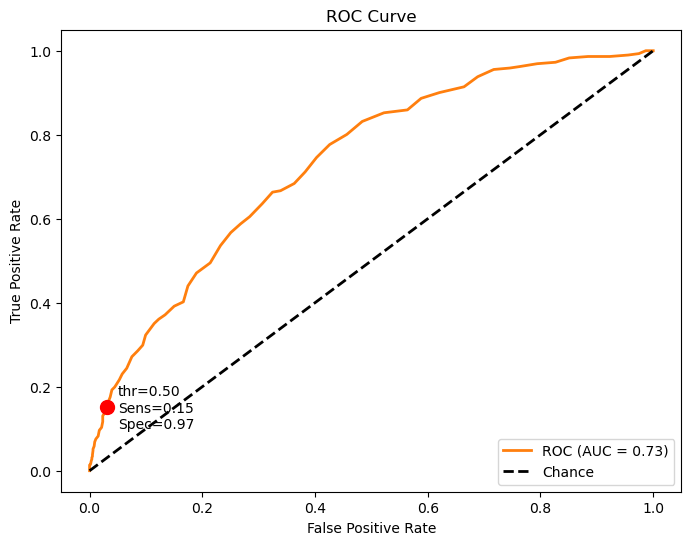

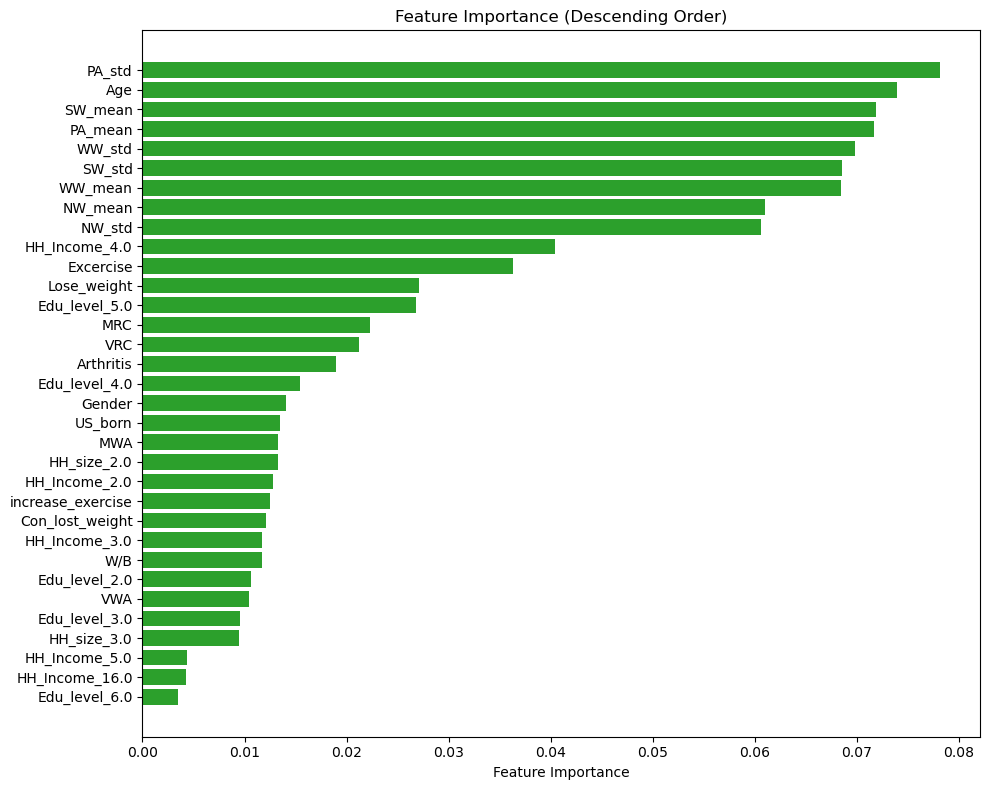

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split

# 1) Prepare your X/y
pre = machine_data.drop(columns=['Health_status'])
tar = machine_data['Health_status']

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    pre, tar,
    test_size=0.3,
    random_state=42,
    stratify=tar
)

# 3) Train
rf_clf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)
rf_clf.fit(X_train, y_train)

# 4) Predict & evaluate
y_pred = rf_clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 5) ROC/AUC
y_proba = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'C1-', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2, label='Chance')
# annotate threshold=0.5
ix = np.argmin(np.abs(thresholds - 0.5))
plt.scatter(fpr[ix], tpr[ix], c='red', s=100, zorder=5)
plt.text(
    fpr[ix]+0.02, tpr[ix]-0.05,
    f"thr={thresholds[ix]:.2f}\nSens={tpr[ix]:.2f}\nSpec={(1-fpr[ix]):.2f}"
)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 6) Feature importances
green_hex = '#2ca02c'
feature_importances = rf_clf.feature_importances_


feature_names = pre.columns.tolist()

# Sort descending
indices_desc = np.argsort(feature_importances)[::-1]
labels_desc  = [feature_names[i] for i in indices_desc]
colors       = [green_hex for _ in indices_desc]

plt.figure(figsize=(10, 8))
plt.barh(labels_desc, feature_importances[indices_desc], color=colors)
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Descending Order)')
plt.gca().invert_yaxis()   # puts largest at top
plt.tight_layout()
plt.show()


In [129]:
machine_data.head()

,PA_mean,PA_std,WW_mean,WW_std,SW_mean,SW_std,NW_mean,NW_std,VWA,MWA,W/B,VRC,MRC,Gender,Age,US_born,Health_status,Arthritis,Lose_weight,Excercise,Con_lost_weight,increase_exercise,HH_Income_16.0,HH_Income_2.0,HH_Income_3.0,HH_Income_4.0,HH_Income_5.0,HH_size_2.0,HH_size_3.0,Edu_level_2.0,Edu_level_3.0,Edu_level_4.0,Edu_level_5.0,Edu_level_6.0
0,0.098,0.380,0.169,0.027,0.017,0.438,-0.131,0.492,1.0,1.0,1.0,1.0,1.0,0.0,22.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,False,False,False,True,False,False,True,False,False,False,True,False
3,-0.413,-0.480,0.692,-0.401,-0.026,-0.269,-0.572,-1.026,1.0,1.0,1.0,1.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False,False,False,False
6,-2.204,-0.583,-3.575,-1.448,-2.333,-0.080,4.188,2.368,1.0,1.0,1.0,1.0,1.0,1.0,43.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,False,True,False,False,False,False,False,False,True,False,False,False
7,-0.903,-0.613,0.041,0.374,-0.053,0.352,-0.017,1.145,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,False,False,True,False,False,True,False,False,False,True,False,False
8,-1.074,-1.489,-0.464,-1.355,1.363,-0.126,-0.486,-0.661,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,False,True,False,False,False


In [130]:

machine_data.reset_index(drop=True, inplace=True)


# Complete data with the stats model - Logistic Regression

                           Logit Regression Results                           
Dep. Variable:          Health_status   No. Observations:                 2977
Model:                          Logit   Df Residuals:                     2943
Method:                           MLE   Df Model:                           33
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.1768
Time:                        10:14:02   Log-Likelihood:                -1316.9
converged:                       True   LL-Null:                       -1599.7
Covariance Type:            nonrobust   LLR p-value:                 2.926e-98
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.4850      0.344     -4.314      0.000      -2.160      -0.810
PA_mean              -0.4776      0.178     -2.684      0.007      -0.826      -0.129
PA_std                0.

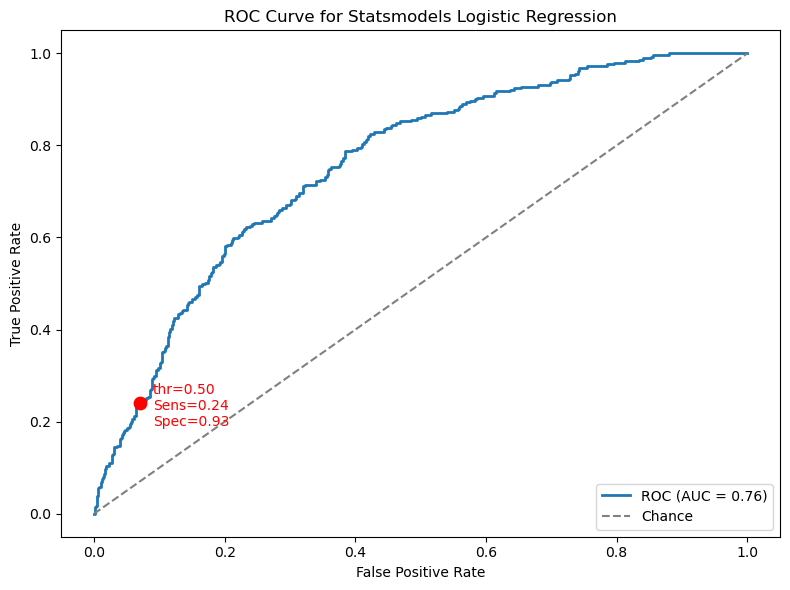

In [132]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 0) One‑hot encode all non-numeric columns in the features
X_raw = machine_data.drop(columns='Health_status')
X = pd.get_dummies(X_raw, drop_first=True)

# 1) Ensure target is integer
y = machine_data['Health_status'].astype(int)

# 2) Train/test split (70/30 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3) Add intercept and cast to float
X_train_const = sm.add_constant(X_train).astype(float)
X_test_const  = sm.add_constant(X_test) .astype(float)

# 4) Fit the logistic regression
logit_model = sm.Logit(y_train, X_train_const).fit(disp=False)

# 5) Summary
print(logit_model.summary())

# 6) Predict probabilities
y_proba = logit_model.predict(X_test_const)

# 7) ROC / AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 8) Plot ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray', label='Chance')
idx = np.argmin(np.abs(thresholds - 0.5))
plt.scatter(fpr[idx], tpr[idx], color='red', s=80, zorder=5)
plt.text(fpr[idx]+0.02, tpr[idx]-0.05,
         f"thr={thresholds[idx]:.2f}\nSens={tpr[idx]:.2f}\nSpec={(1-fpr[idx]):.2f}",
         color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Statsmodels Logistic Regression')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Apply cross validation for the stats models logistic regresssion

In [180]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score


X_raw = machine_data.drop(columns='Health_status')
X = pd.get_dummies(X_raw, drop_first=True).astype(float)
y = machine_data['Health_status'].astype(int)


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)

scores = []


for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    
    X_tr_const = sm.add_constant(X_tr)
    X_te_const = sm.add_constant(X_te)
    
    # Fit statsmodels Logit
    model = sm.Logit(y_tr, X_tr_const).fit(disp=False)
    
    # Predict probabilities and convert to binary (0/1) at 0.5 threshold
    y_pred = (model.predict(X_te_const) >= 0.5).astype(int)
    
    # Compute accuracy for this fold
    scores.append(accuracy_score(y_te, y_pred))

scores = np.array(scores)
print(f"Total fits:   {len(scores)}")      # should be 100
print(f"Mean accuracy: {scores.mean():.4f}")
print(f"Std  accuracy: {scores.std():.4f}")


Total fits:   100
Mean accuracy: 0.7845
Std  accuracy: 0.0101


In [135]:
machine_data.columns

Index(['PA_mean', 'PA_std', 'WW_mean', 'WW_std', 'SW_mean', 'SW_std',
       'NW_mean', 'NW_std', 'VWA', 'MWA', 'W/B', 'VRC', 'MRC', 'Gender', 'Age',
       'US_born', 'Health_status', 'Arthritis', 'Lose_weight', 'Excercise',
       'Con_lost_weight', 'increase_exercise', 'HH_Income_16.0',
       'HH_Income_2.0', 'HH_Income_3.0', 'HH_Income_4.0', 'HH_Income_5.0',
       'HH_size_2.0', 'HH_size_3.0', 'Edu_level_2.0', 'Edu_level_3.0',
       'Edu_level_4.0', 'Edu_level_5.0', 'Edu_level_6.0'],
      dtype='object')

In [136]:
machine_data.shape

(4254, 34)

In [137]:
obj_col = ['PA_mean', 'PA_std', 'WW_mean', 'WW_std', 'SW_mean', 'SW_std',
       'NW_mean', 'NW_std','Gender', 'Age',
       'US_born','HH_Income_16.0',
       'HH_Income_2.0', 'HH_Income_3.0', 'HH_Income_4.0', 'HH_Income_5.0',
       'HH_size_2.0', 'HH_size_3.0', 'Edu_level_2.0', 'Edu_level_3.0',
       'Edu_level_4.0', 'Edu_level_5.0', 'Edu_level_6.0']

In [138]:
len(obj_col)

23

In [139]:
print(type(obj_col))

<class 'list'>


In [140]:
sub_col = ['VWA', 'MWA', 'W/B', 'VRC', 'MRC', 'Gender', 'Age',
       'US_born','Arthritis', 'Lose_weight', 'Excercise',
       'Con_lost_weight', 'increase_exercise', 'HH_Income_16.0',
       'HH_Income_2.0', 'HH_Income_3.0', 'HH_Income_4.0', 'HH_Income_5.0',
       'HH_size_2.0', 'HH_size_3.0', 'Edu_level_2.0', 'Edu_level_3.0',
       'Edu_level_4.0', 'Edu_level_5.0', 'Edu_level_6.0']

In [141]:
len(sub_col)

25

In [142]:
target = 'Health_status'

In [143]:
obj_data = machine_data[obj_col + [target]].copy()

In [144]:
print(type(obj_data))

<class 'pandas.core.frame.DataFrame'>


In [145]:
sub_data = machine_data[sub_col + [target]].copy()

In [146]:
print(type(sub_data))

<class 'pandas.core.frame.DataFrame'>


In [147]:
obj_data.head(10)

,PA_mean,PA_std,WW_mean,WW_std,SW_mean,SW_std,NW_mean,NW_std,Gender,Age,US_born,HH_Income_16.0,HH_Income_2.0,HH_Income_3.0,HH_Income_4.0,HH_Income_5.0,HH_size_2.0,HH_size_3.0,Edu_level_2.0,Edu_level_3.0,Edu_level_4.0,Edu_level_5.0,Edu_level_6.0,Health_status
0,0.098,0.380,0.169,0.027,0.017,0.438,-0.131,0.492,0.0,22.0,0.0,False,False,False,True,False,False,True,False,False,False,True,False,0.0
1,-0.413,-0.480,0.692,-0.401,-0.026,-0.269,-0.572,-1.026,0.0,21.0,0.0,False,False,False,False,False,False,True,False,False,False,False,False,0.0
2,-2.204,-0.583,-3.575,-1.448,-2.333,-0.080,4.188,2.368,1.0,43.0,0.0,False,True,False,False,False,False,False,False,True,False,False,False,0.0
3,-0.903,-0.613,0.041,0.374,-0.053,0.352,-0.017,1.145,0.0,80.0,0.0,False,False,True,False,False,True,False,False,False,True,False,False,1.0
4,-1.074,-1.489,-0.464,-1.355,1.363,-0.126,-0.486,-0.661,0.0,80.0,0.0,False,False,False,False,False,False,False,False,True,False,False,False,1.0
5,-1.320,-1.688,-1.747,-0.984,-1.255,-0.172,-0.609,-1.183,0.0,55.0,0.0,False,False,False,True,False,True,False,False,False,False,True,False,0.0
6,0.356,0.293,0.413,0.612,0.135,-0.499,-0.335,-0.015,0.0,35.0,0.0,False,True,False,False,False,True,False,False,False,False,True,False,0.0
7,0.517,-0.580,0.821,-1.144,0.066,-0.289,-0.603,-1.159,0.0,26.0,0.0,False,False,False,True,False,False,True,False,False,True,False,False,0.0
8,1.392,0.584,0.930,0.064,-0.742,-0.477,-0.145,0.036,1.0,30.0,0.0,False,False,True,False,False,True,False,False,False,True,False,False,0.0
9,-1.149,-1.276,-0.395,-0.905,1.423,-0.059,-0.522,-0.813,0.0,70.0,0.0,False,False,False,True,False,True,False,False,False,False,False,True,0.0


In [148]:
obj_data.shape

(4254, 24)

In [149]:
sub_data.head()

,VWA,MWA,W/B,VRC,MRC,Gender,Age,US_born,Arthritis,Lose_weight,Excercise,Con_lost_weight,increase_exercise,HH_Income_16.0,HH_Income_2.0,HH_Income_3.0,HH_Income_4.0,HH_Income_5.0,HH_size_2.0,HH_size_3.0,Edu_level_2.0,Edu_level_3.0,Edu_level_4.0,Edu_level_5.0,Edu_level_6.0,Health_status
0,1.0,1.0,1.0,1.0,1.0,0.0,22.0,0.0,0.0,1.0,0.0,1.0,1.0,False,False,False,True,False,False,True,False,False,False,True,False,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False,False,False,False,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,43.0,0.0,0.0,0.0,0.0,1.0,1.0,False,True,False,False,False,False,False,False,True,False,False,False,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,1.0,1.0,1.0,1.0,False,False,True,False,False,True,False,False,False,True,False,False,1.0
4,1.0,1.0,1.0,1.0,1.0,0.0,80.0,0.0,1.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,False,True,False,False,False,1.0


# Complete data with the oversampling of Stats model - Logistic Regression

In [ ]:
x = machine_data.drop(columns=['Health_status'])
y = machine_data['Health_status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import statsmodels.api as sm

# 1) Original split (you already have these)
# X_train, X_test, y_train, y_test

# 2) Oversample the training set
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

# 3) Add intercept and ensure float dtype
X_res_const = sm.add_constant(X_res).astype(float)
X_test_const = sm.add_constant(X_test).astype(float)

# 4) Refit the logistic regression on the oversampled data
logit_oversampled = sm.Logit(y_res, X_res_const).fit(disp=False)

# 5) View the new summary
print(logit_oversampled.summary())

# 6) (Optional) Plot updated ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba_os = logit_oversampled.predict(X_test_const)
fpr, tpr, _ = roc_curve(y_test, y_proba_os)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f'AOC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('Logit ROC with Random Oversampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# over sampling for the random forest model.

In [ ]:
x = machine_data.drop(columns=['Health_status'])
y = machine_data['Health_status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:

# 2) Oversample the training set
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [ ]:
rf_clf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)
rf_clf.fit(X_res, y_res)

# 4) Predict & evaluate
y_pred = rf_clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 5) ROC/AUC
y_proba = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'C1-', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2, label='Chance')
# annotate threshold=0.5
ix = np.argmin(np.abs(thresholds - 0.5))
plt.scatter(fpr[ix], tpr[ix], c='red', s=100, zorder=5)
plt.text(
    fpr[ix]+0.02, tpr[ix]-0.05,
    f"thr={thresholds[ix]:.2f}\nSens={tpr[ix]:.2f}\nSpec={(1-fpr[ix]):.2f}"
)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 6) Feature importances
green_hex = '#2ca02c'
feature_importances = rf_clf.feature_importances_


feature_names = pre.columns.tolist()

# Sort descending
indices_desc = np.argsort(feature_importances)[::-1]
labels_desc  = [feature_names[i] for i in indices_desc]
colors       = [green_hex for _ in indices_desc]

plt.figure(figsize=(10, 8))
plt.barh(labels_desc, feature_importances[indices_desc], color=colors)
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Descending Order)')
plt.gca().invert_yaxis()   # puts largest at top
plt.tight_layout()
plt.show()


In [ ]:





# 6) (Optional) Plot updated ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba_os = logit_oversampled.predict(X_test_const)
fpr, tpr, _ = roc_curve(y_test, y_proba_os)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f'AOC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('Logit ROC with Random Oversampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Random Forest with the Object_data

OBJ_DATA | Random Forest
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       986
           1       0.46      0.08      0.13       291

    accuracy                           0.77      1277
   macro avg       0.62      0.52      0.50      1277
weighted avg       0.71      0.77      0.70      1277

[[960  26]
 [269  22]]


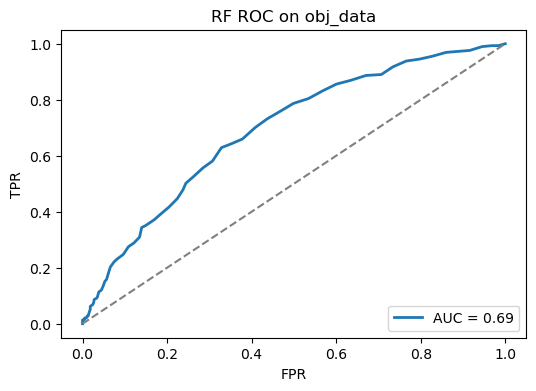

In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Prepare features/target
X2 = obj_data.drop(columns='Health_status')
y2 = obj_data['Health_status'].astype(int)

# Split
X_tr, X_te, y_tr, y_te = train_test_split(
    X2, y2, test_size=0.3, random_state=42, stratify=y
)

# Train
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_tr, y_tr)

# Predict & evaluate
y_pred = rf.predict(X_te)
print("OBJ_DATA | Random Forest")
print(classification_report(y_te, y_pred))
print(confusion_matrix(y_te, y_pred))

# ROC
y_proba = rf.predict_proba(X_te)[:, 1]
fpr, tpr, _ = roc_curve(y_te, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', lw=2)
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('RF ROC on obj_data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()


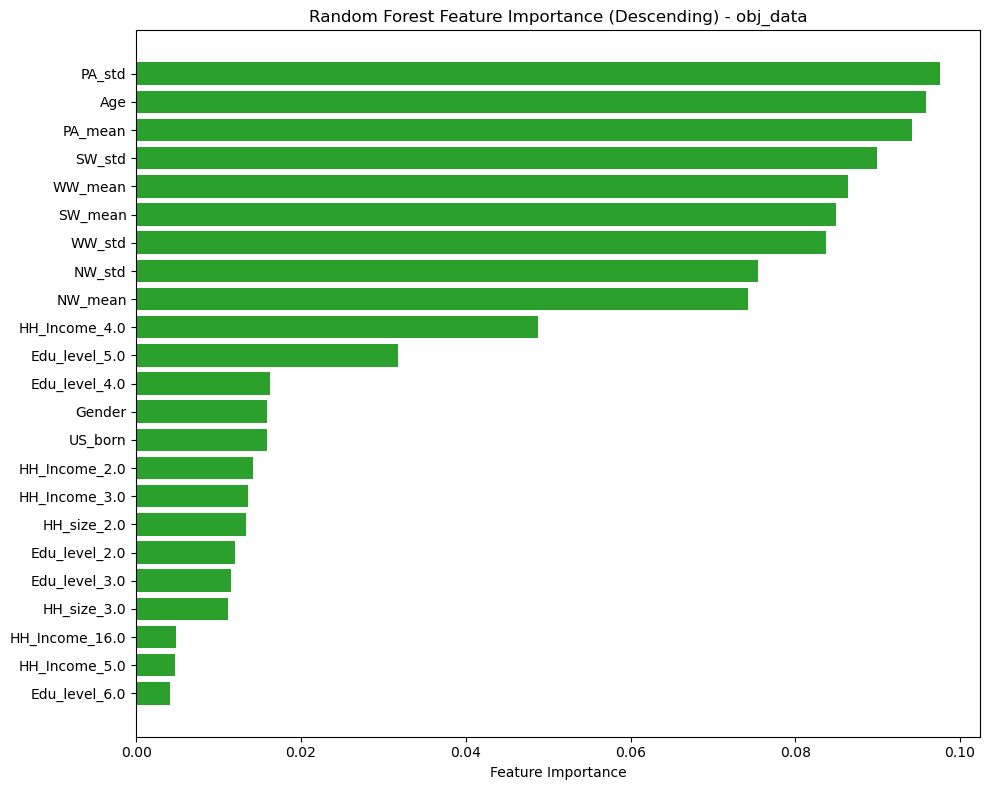

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already trained 'rf' on obj_data as per previous snippet,
# and X_tr is the training features DataFrame

# 1. Get feature importances and feature names
feature_importances = rf.feature_importances_
feature_names = X_tr.columns.tolist()

# 2. Sort indices in descending order
indices_desc = np.argsort(feature_importances)[::-1]

# 3. Build labels and colors
labels_desc = [feature_names[i] for i in indices_desc]
colors = ['#2ca02c'] * len(labels_desc)  # using the green_hex you defined

# 4. Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(labels_desc, feature_importances[indices_desc], color=colors)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Descending) - obj_data')
plt.gca().invert_yaxis()  # largest importance on top
plt.tight_layout()
plt.show()


# obj data cross validation 

In [167]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)


scores = cross_val_score(rf, X2, y2, cv=cv, scoring='accuracy', n_jobs=-1)


print("All 100 accuracies:\n", scores)


print(f"\nMean accuracy: {scores.mean():.4f}")
print(f"Std  accuracy: {scores.std():.4f}")

All 100 accuracies:
 [0.7826087  0.77673325 0.76380729 0.77085781 0.76352941 0.77438308
 0.77555817 0.76733255 0.7720329  0.77764706 0.77438308 0.77438308
 0.77908343 0.78025852 0.77411765 0.75910693 0.78025852 0.77085781
 0.78378378 0.77411765 0.77320799 0.77555817 0.77438308 0.76850764
 0.77529412 0.77673325 0.77438308 0.76850764 0.77320799 0.78352941
 0.77673325 0.77908343 0.77673325 0.77555817 0.76352941 0.77555817
 0.7720329  0.77320799 0.76733255 0.76705882 0.78025852 0.76850764
 0.77673325 0.76498237 0.77882353 0.76733255 0.7720329  0.7720329
 0.7720329  0.76588235 0.7720329  0.76968273 0.77555817 0.77438308
 0.77882353 0.77673325 0.77320799 0.76498237 0.76145711 0.77647059
 0.77085781 0.76850764 0.77320799 0.77438308 0.77411765 0.76850764
 0.7626322  0.78495887 0.76028202 0.77411765 0.78143361 0.78025852
 0.77320799 0.76850764 0.76117647 0.77438308 0.78025852 0.78025852
 0.77555817 0.78117647 0.77438308 0.77908343 0.77320799 0.77085781
 0.76823529 0.76615746 0.77555817 0.773207

# Cross - validation on obj data with change of random state.

In [170]:
mean_scores = []
for seed in range(1, 101):
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
 
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=seed,
        class_weight='balanced'
    )
    
   
    scores = cross_val_score(
        rf, X2 , y2,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    mean_scores.append(scores.mean())


print("100 model mean accuracies:\n", mean_scores)


mean_scores = np.array(mean_scores)
print(f"\nOverall mean: {mean_scores.mean():.4f}")
print(f"Overall std:  {mean_scores.std():.4f}")


100 model mean accuracies:
 [0.7743297159051634, 0.7731549042648787, 0.7747983687011819, 0.7719789866592935, 0.7759742863067671, 0.7769160157600055, 0.7719756687633925, 0.7719784336766434, 0.7745658394967858, 0.7755053570194235, 0.771510333863275, 0.7726821040989839, 0.7731557337388539, 0.7710380866800305, 0.770099675122693, 0.7738624455657704, 0.77503698071473, 0.7715103338632752, 0.7747986451925071, 0.7724492984032626, 0.7750358747494298, 0.7710416810672565, 0.7748000276491325, 0.7736207921476465, 0.7712758692196033, 0.7731549042648787, 0.7745619686182346, 0.7733901983825258, 0.7715108868459253, 0.7724495748945877, 0.7745644570401604, 0.7748005806317827, 0.7724512338425382, 0.7762106863897146, 0.7776199626736712, 0.7750331098361789, 0.7745674984447363, 0.7726843160295847, 0.7736241100435475, 0.7731549042648787, 0.7736249395175226, 0.7715072924586991, 0.772917674707956, 0.7729182276906063, 0.7715083984239993, 0.7717436925416464, 0.7726832100642842, 0.772920716112532, 0.771508121932674

# Logistic Regression (statsmodels) on obj_data

OBJ_DATA | Statsmodels Logit Summary
                           Logit Regression Results                           
Dep. Variable:          Health_status   No. Observations:                 2977
Model:                          Logit   Df Residuals:                     2953
Method:                           MLE   Df Model:                           23
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.1210
Time:                        10:41:03   Log-Likelihood:                -1406.1
converged:                       True   LL-Null:                       -1599.7
Covariance Type:            nonrobust   LLR p-value:                 7.375e-68
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5598      0.271     -2.069      0.039      -1.090      -0.029
PA_mean           -0.5463      0.172     -3.171      0.002      -0.884      -0.209

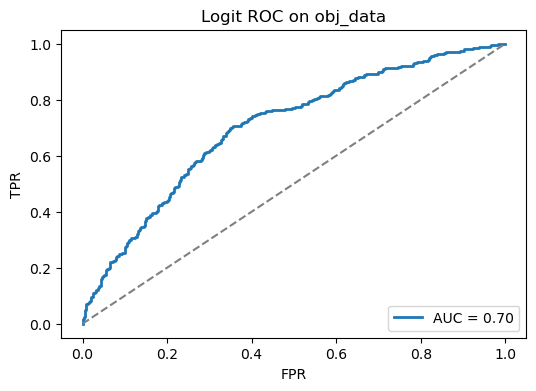

In [176]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prepare & one‑hot encode
X_raw = obj_data.drop(columns='Health_status')
X = pd.get_dummies(X_raw, drop_first=True)
y = obj_data['Health_status'].astype(int)

# Split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Add intercept & cast
X_tr_const = sm.add_constant(X_tr).astype(float)
X_te_const = sm.add_constant(X_te).astype(float)

# Fit
logit = sm.Logit(y_tr, X_tr_const).fit(disp=False)
print("OBJ_DATA | Statsmodels Logit Summary")
print(logit.summary())

# ROC
y_proba = logit.predict(X_te_const)
fpr, tpr, _ = roc_curve(y_te, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('Logit ROC on obj_data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()


# Random Forest on sub_data

SUB_DATA | Random Forest
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       986
           1       0.43      0.23      0.30       291

    accuracy                           0.75      1277
   macro avg       0.62      0.57      0.58      1277
weighted avg       0.72      0.75      0.73      1277

[[896  90]
 [223  68]]


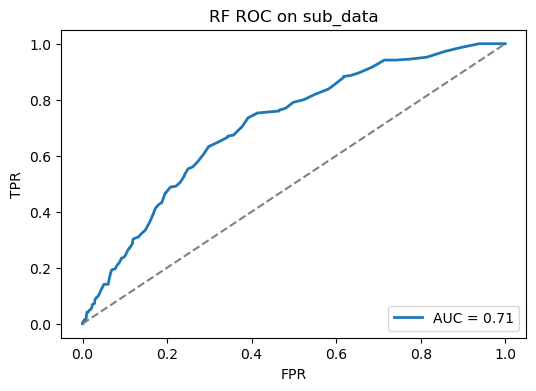

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Prepare
X3 = sub_data.drop(columns='Health_status')
y3 = sub_data['Health_status'].astype(int)

# Split
X_tr, X_te, y_tr, y_te = train_test_split(
    X3, y3, test_size=0.3, random_state=42, stratify=y
)

# Train
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_tr, y_tr)

# Evaluate
y_pred = rf.predict(X_te)
print("SUB_DATA | Random Forest")
print(classification_report(y_te, y_pred))
print(confusion_matrix(y_te, y_pred))

# ROC
y_proba = rf.predict_proba(X_te)[:, 1]
fpr, tpr, _ = roc_curve(y_te, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('RF ROC on sub_data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()


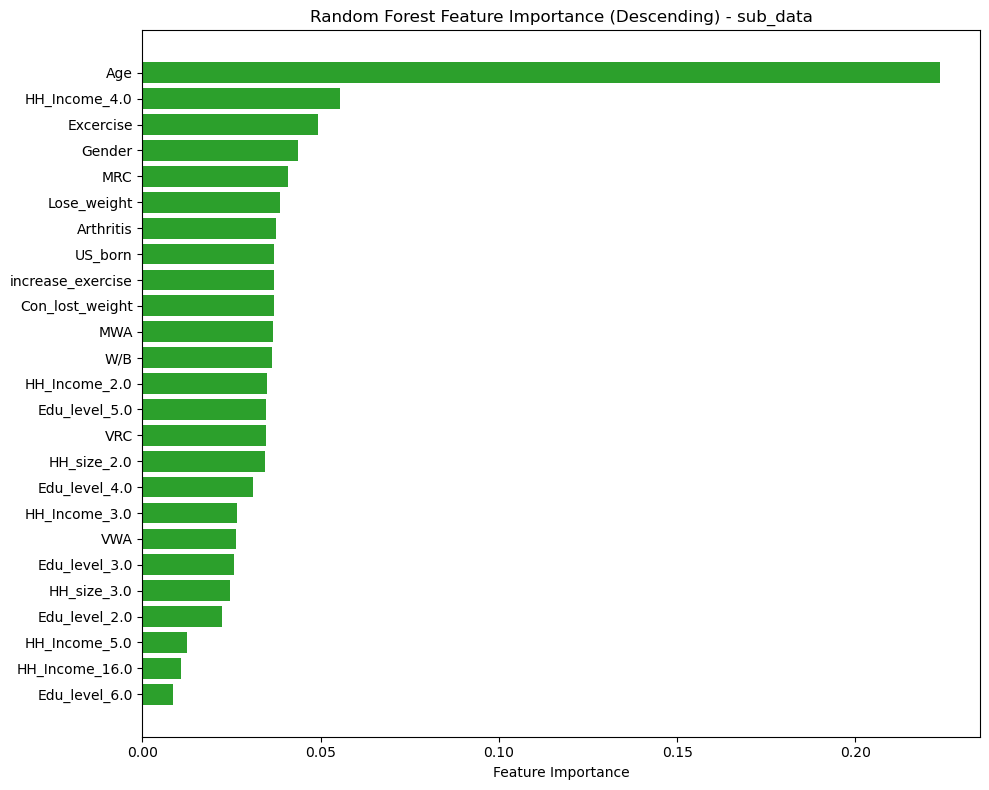

In [153]:
importances = rf.feature_importances_
feature_names = X_tr.columns.tolist()

# 2. Sort features by importance in descending order
indices_desc = np.argsort(importances)[::-1]
sorted_importances = importances[indices_desc]
sorted_names = [feature_names[i] for i in indices_desc]

# 3. Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(sorted_names, sorted_importances, color='#2ca02c')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Descending) - sub_data')
plt.gca().invert_yaxis()   # ensures the most important feature appears at the top
plt.tight_layout()
plt.show()

In [155]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)

# 4) Get array of scores
scores = cross_val_score(rf, X3, y3, cv=cv, scoring='accuracy', n_jobs=-1)

# 5) Print the raw array of 100 accuracies
print("All 100 accuracies:\n", scores)


# 7) And you can still get the mean & std
print(f"\nMean accuracy: {scores.mean():.4f}")
print(f"Std  accuracy: {scores.std():.4f}")

All 100 accuracies:
 [0.77790834 0.76380729 0.75910693 0.76615746 0.77058824 0.76733255
 0.74970623 0.78495887 0.75793184 0.77411765 0.76733255 0.77320799
 0.77673325 0.76145711 0.77647059 0.7520564  0.76380729 0.75675676
 0.76615746 0.77529412 0.78025852 0.76733255 0.76733255 0.78965922
 0.77176471 0.76850764 0.7720329  0.76145711 0.78025852 0.77882353
 0.7720329  0.77908343 0.76968273 0.75440658 0.74823529 0.76028202
 0.76733255 0.77790834 0.78025852 0.76941176 0.76850764 0.76145711
 0.77555817 0.75675676 0.77411765 0.74853114 0.78613396 0.76145711
 0.76968273 0.77764706 0.75323149 0.78495887 0.76968273 0.7720329
 0.77411765 0.77085781 0.77438308 0.75440658 0.76380729 0.76117647
 0.77555817 0.79083431 0.76380729 0.76145711 0.77882353 0.77320799
 0.75910693 0.7720329  0.76968273 0.77529412 0.76498237 0.77790834
 0.77908343 0.77790834 0.75294118 0.76968273 0.76968273 0.77673325
 0.76850764 0.76470588 0.78613396 0.76850764 0.75558167 0.78730905
 0.76352941 0.77908343 0.78143361 0.779083

# sub_data with different random state

In [174]:
mean_scores = []
for seed in range(1, 101):
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
 
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=seed,
        class_weight='balanced'
    )
    
   
    scores = cross_val_score(
        rf, X3 , y3,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    mean_scores.append(scores.mean())


print("100 model mean accuracies:\n", mean_scores)


mean_scores = np.array(mean_scores)
print(f"\nOverall mean: {mean_scores.mean():.4f}")
print(f"Overall std:  {mean_scores.std():.4f}")

100 model mean accuracies:
 [0.770331651344439, 0.7740982926660676, 0.7745644570401604, 0.7736257689914978, 0.7731535218082531, 0.7686881869081358, 0.7757414806110459, 0.767043340015207, 0.7623432639800927, 0.7738574687219189, 0.7705683279187115, 0.7731549042648787, 0.7738607866178198, 0.7689254164650583, 0.7684548282297643, 0.7726845925209097, 0.7733896453998755, 0.7679811985898942, 0.7712755927282782, 0.7682170456901914, 0.7740922098569157, 0.7675147577244764, 0.769626321974148, 0.7712708923757517, 0.7724490219119374, 0.7684575931430151, 0.7686865279601853, 0.7747991981751572, 0.7703327573097394, 0.773152415842953, 0.7738629985484206, 0.7717478399115227, 0.7710402986106312, 0.771275039745628, 0.7691579456694546, 0.7675144812331514, 0.7726865279601853, 0.7705719223059377, 0.7750342158014792, 0.7757378862238197, 0.7733893689085505, 0.767513651759176, 0.7691604340913804, 0.7682164927075413, 0.7752672979885256, 0.7708055574756342, 0.7682181516554918, 0.7715117163199005, 0.768219810603442

# Logistic Regression (statsmodels) on sub_data

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prepare & encode
X = sub_data.drop(columns='Health_status')
y = sub_data['Health_status'].astype(int)

# Split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Intercept
X_tr_const = sm.add_constant(X_tr).astype(float)
X_te_const = sm.add_constant(X_te).astype(float)

# Fit
logit = sm.Logit(y_tr, X_tr_const).fit(disp=False)
print("SUB_DATA | Statsmodels Logit Summary")
print(logit.summary())

# ROC
y_proba = logit.predict(X_te_const)
fpr, tpr, _ = roc_curve(y_te, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('Logit ROC on sub_data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()
